# Integration of Mouse Organogenesis

For our integrated dataset, we seek to obtain cell type-averaged counts from the epithelium/mesechyme during mouse organogenesis `e95, e10.5, e11.5` mice ([Dong et al., 2018](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1416-2)).

For the dataset integration, we assume the authors have performed satisfactory quality control on cells. We will also take all genes from the raw data so that we can maximize on the number of genes in the integrated dataset, since we take the intersection of genes. Finally, for reasonable comparison, we will normalize all cells to have the same total counts, `1e4`.

In [1]:
import numpy as np
import scanpy as sc
import scipy as sp
import pandas as pd
import seaborn as sb

import module as md

datadir = '../../data/raw_data/sc_data/epithelial_mesenchymal_transition/'
resdir = '../../data/processed_data/sc_data/epithelial_mesenchymal_transition/'

In [2]:
file_name = datadir+'matrix.csv'
adata = sc.read_csv(file_name).T
adata

AnnData object with n_obs × n_vars = 1916 × 23154

[Dong et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1416-2) sequenced several tissues in two biological replicates from E9.5-E11.5 days in mouse development, and here, we analyze the sequenced forebrain tissues from their dataset.

GEO Accession: [GSE87038](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi)

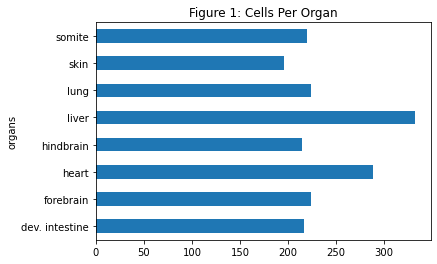

In [3]:
organ = []
for name in list(adata.obs.index):
    if 'forebrain' in name:
        organ.append('forebrain')
    elif 'heart' in name:
        organ.append('heart')
    elif 'intestine' in name:
        organ.append('dev. intestine')
    elif 'liver' in name:
        organ.append('liver')
    elif 'hindbrain' in name:
        organ.append('hindbrain')
    elif 'somite' in name:
        organ.append('somite')
    elif 'lung' in name:
        organ.append('lung')
    elif 'skin' in name:
        organ.append('skin')
adata.obs['organs'] = organ

df = pd.DataFrame(adata.obs, columns = ['organs'])
orgs = df.pivot_table(index = ['organs'], aggfunc = 'size')
ax = orgs.plot.barh(title='Figure 1: Cells Per Organ')
fig = ax.get_figure()

The histogram above shows that the forebrain dataset is quite small, which is fine if the sequencing is of high-quality.

The paper provides additional metadata for the dataset. In their analysis of hindbrain data, they labeled biological replicates, deveopmental stage, and neuronal cells. We will annotate our AnnData object with these labels as well.

In [4]:
# Labeling batches here

batch = []
stage = []
for name in list(adata.obs.index):
    if 'E9.5_embryo1' in name:
        batch.append('E9.5_embryo1')
        stage.append('E9.5')
    elif 'E9.5_embryo2' in name:
        batch.append('E9.5_embryo2')
        stage.append('E9.5')
    elif 'E9.5_embryo3' in name:
        batch.append('E9.5_embryo3')
        stage.append('E9.5')
    elif 'E10.5_embryo1' in name:
        batch.append('E10.5_embryo1')
        stage.append('E10.5')
    elif 'E10.5_embryo2' in name:
        batch.append('E10.5_embryo2')
        stage.append('E10.5')
    elif 'E11.5_embryo1' in name:
        batch.append('E11.5_embryo1')
        stage.append('E11.5')
    elif 'E11.5_embryo2' in name:
        batch.append('E11.5_embryo2')
        stage.append('E11.5')

adata.obs['batch'] = batch
adata.obs["stage"] = stage

In [5]:
ct_df = pd.read_csv(datadir+"cell_assignments.csv",index_col=0,header=1)
ct_df["age"] = [i[1] for i in ct_df.index.str.split("_")]
ct_df["embryo"] = [i[2] for i in ct_df.index.str.split("_")]

In [6]:
ct_df.head()

,Cluster,Organ,age,embryo
Cell,,,,
forebrain_E9.5_embryo2_sc85,HC,forebrain,E9.5,embryo2
forebrain_E10.5_embryo2_sc2,HC,forebrain,E10.5,embryo2
forebrain_E10.5_embryo2_sc5,HC,forebrain,E10.5,embryo2
forebrain_E10.5_embryo2_sc8,HC,forebrain,E10.5,embryo2
forebrain_E10.5_embryo2_sc9,HC,forebrain,E10.5,embryo2


In [14]:
df = pd.DataFrame(ct_df.groupby(["Organ", "age", "Cluster"]).size())
df = df.rename(columns = {0: "ncells"})
df = df[df["ncells"] > 0].reset_index()
df = df[df["ncells"] > 20]

df

,Organ,age,Cluster,ncells
2,forebrain,E10.5,NC,36
4,forebrain,E11.5,NC,60
7,forebrain,E9.5,NC,88
10,heart,E10.5,MC,79
13,heart,E11.5,MC,69
15,heart,E9.5,MC,90
18,hindbrain,E10.5,NC,58
20,hindbrain,E11.5,NC,52
23,hindbrain,E9.5,NC,75
26,intestine,E10.5,MC,40


In [15]:
df.groupby(["Cluster", "Organ"]).size()

Cluster  Organ    
EC       intestine    2
         liver        1
         lung         1
         skin         2
HC       liver        2
MC       heart        3
         intestine    2
         liver        1
         lung         3
         skin         2
         somite       3
NC       forebrain    3
         hindbrain    3
dtype: int64

In [10]:
df = pd.DataFrame(ct_df.groupby(["age", "Organ", "Cell"]).size())
df = df.rename(columns = {0: "ncells"})
df = df[df["ncells"] > 0].reset_index()
df = df[df["ncells"] >= 30]
df = df.drop(columns="ncells")
df.shape

(0, 3)

In [11]:
df

,age,Organ,Cell


In [7]:
# Choosing cells labeled as forebrain cells in the paper

forebrain = (adata[adata.obs['organs'] == 'forebrain'])

# Choosing cells defined only as neuronal cells (NC) in the paper

cell_assign = pd.read_csv(datadir+'cell_assignments.csv')
new_header = cell_assign.iloc[0]
cell_assign = cell_assign[1:]
cell_assign.columns = new_header

nc_cell_list = [cell for cell in list(forebrain.obs.index) if cell  in list(cell_assign[cell_assign['Cluster'] == 'NC']['Cell'])]
forebrain = forebrain[nc_cell_list, :]

### Pre-Processing

Our data pre-processing begins with quality control. Below, we visualize our data prior to processing.

Trying to set attribute `.obs` of view, copying.


normalizing counts per cell
    finished (0:00:00)


... storing 'organs' as categorical
... storing 'batch' as categorical
... storing 'stage' as categorical
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


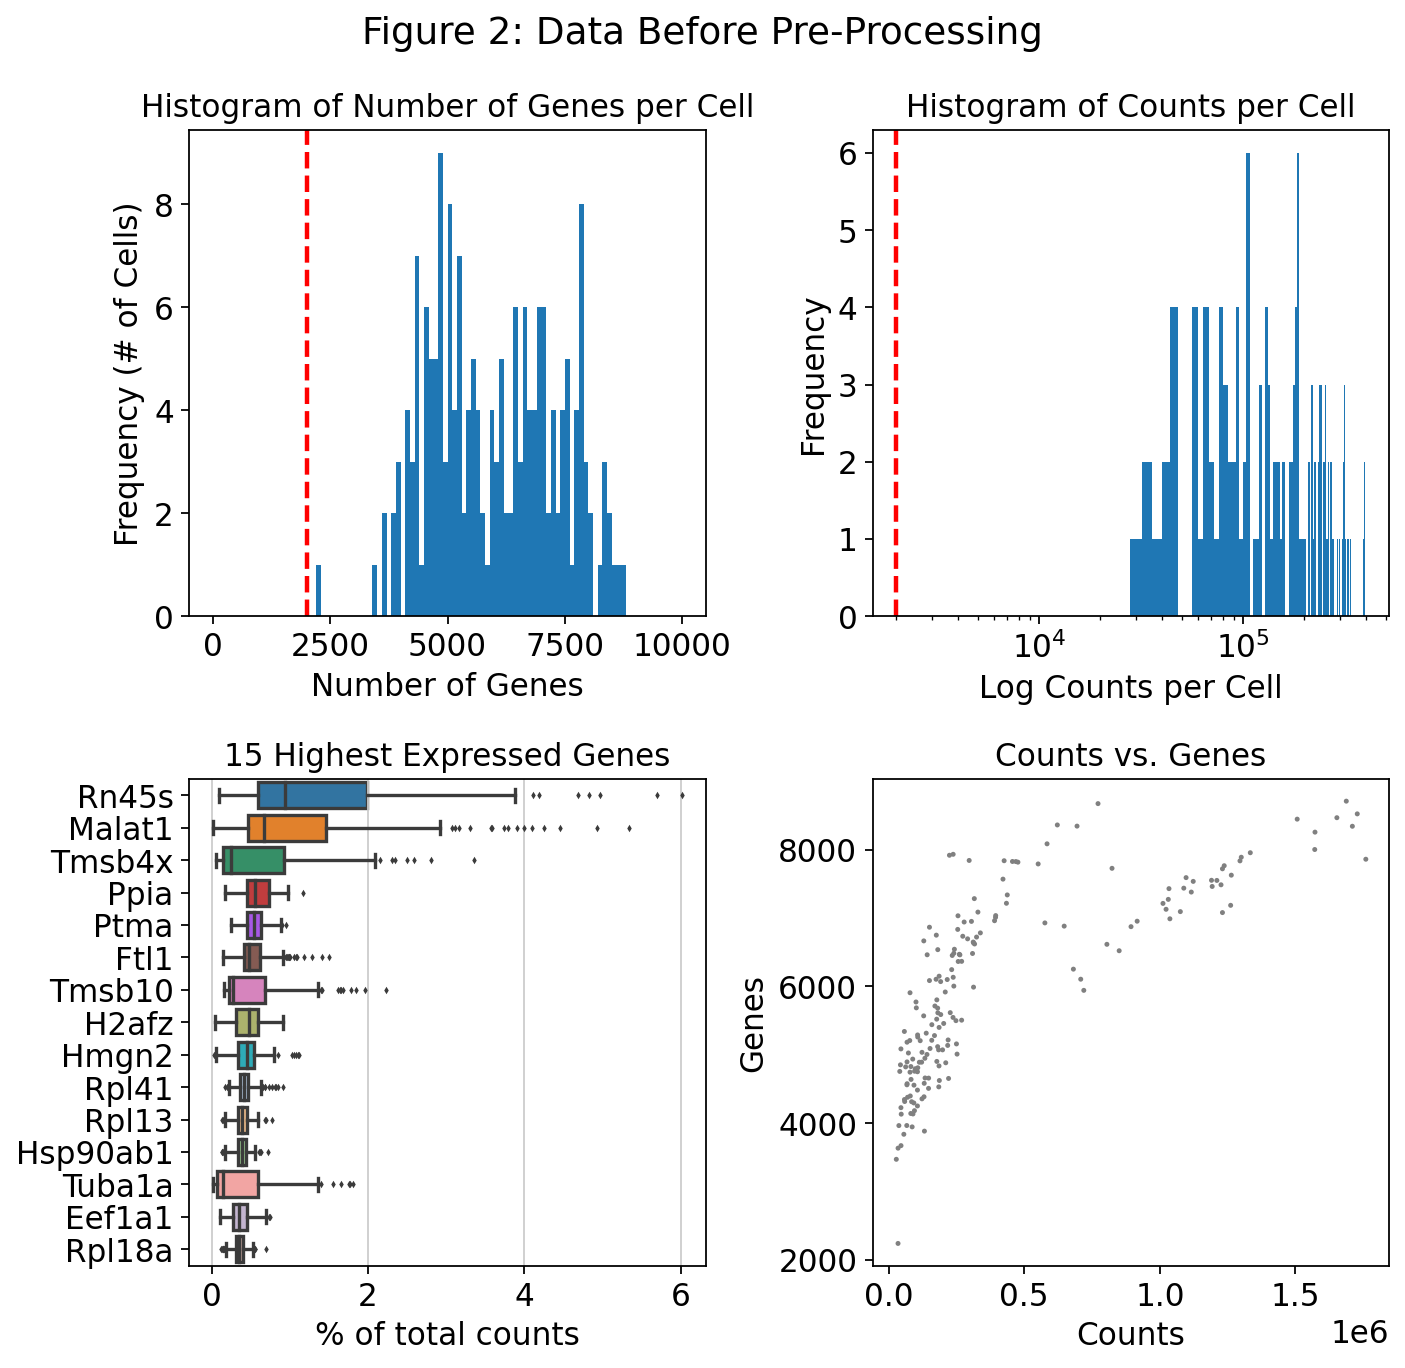

In [8]:
sc.pp.filter_cells(forebrain, min_genes=0)
sc.pp.filter_genes(forebrain, min_cells=0)

# Total counts, cells per gene, and mitochondrial genes
X = np.matrix(forebrain.X)
forebrain.obs['n_total_counts_per_cell'] = (X.sum(axis=1).A1)
forebrain.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1
forebrain.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1

pre_processed = md.vis_pre_processing(forebrain, genes_range=(0, 10000),
    counts_range=(0, 400000),title='Figure 2: Data Before Pre-Processing')
pre_processed.savefig(figdir+"fig2.pdf")

In [9]:
avg_genes = np.average(forebrain.obs['n_genes_per_cell'])
avg_counts = np.average(forebrain.obs['n_total_counts_per_cell'])

print('The average number of genes per cell is ' + str(int(avg_genes)) 
      + ' and the average number of counts per cell is ' 
      + str(int(avg_counts)))

The average number of genes per cell is 6005 and the average number of counts per cell is 406281


The plots above allow us to visualize parameters for our data set, including the number of unique cells and genes captured in the data set, and the distributions of the total number of counts per cell, the total numbers of genes per cell, and the total number of cells per gene. These will allow us to determine our parameters for filtering our data set so we can retain only cells and genes desired.

Below, we adjust the parameters for filtering our cells (based on minimum total counts and the minimum number of genes per cell) and our genes (based on the minimum number of cells the gene is detected in). A high-quality data set for cells has an average of 20,000 counts per cell,  1000-2000 genes per cell, and about 3,000 cells per gene. We can filter genes as some fraction of the total cell count.

filtered out 9245 genes that are detected in less than 3 cells


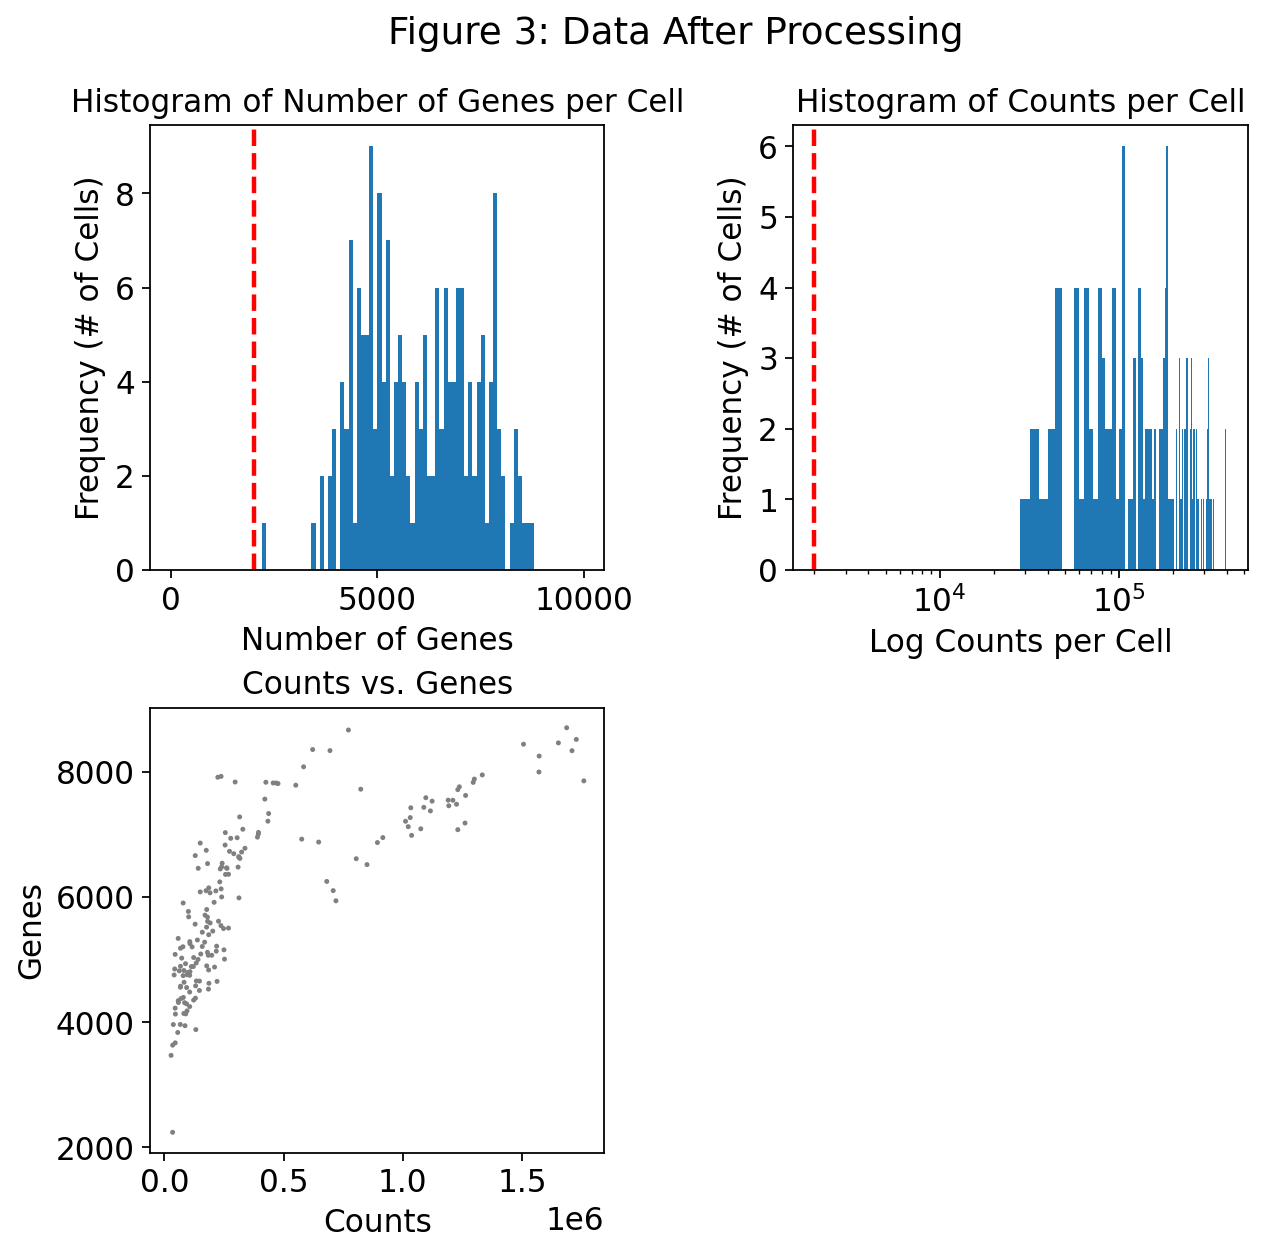

In [10]:
forebrain = md.filter_data(forebrain, min_counts=2000, min_genes=2000, min_cells=3)
post_processing = md.vis_post_processing(forebrain, genes_range=(0, 10000), counts_range=(0, 400000),
                                         title='Figure 3: Data After Processing')
post_processing.savefig(figdir+"fig3.pdf")

Below, we select genes below a certain number of counts. We should note that transcript counts differ between cells, so a comparison of gene expression using total counts would be biased toward cells with higher total counts. To appropriately compare gene expression, we normalize the count data by scaling it based on total counts. For downstream analysis, we normalize the data using a log(x+1) transformation on the number of counts per cell. 

Yet, Hu et al. use a log (x/10 + 1) normalization in their paper, so that is what we apply here.

In [11]:
%%time

pre_norm = forebrain.copy()

sc.pp.normalize_total(forebrain, target_sum=1.75e5)

sc.pp.log1p(forebrain)
forebrain.raw=forebrain
sc.pp.highly_variable_genes(forebrain, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'stage')

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 547 ms, sys: 25.1 ms, total: 572 ms
Wall time: 571 ms


In [12]:
print("Highly variable genes intersection: %d"%sum(forebrain.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(forebrain.var.highly_variable_nbatches.value_counts())

var_genes_batch = forebrain.var.highly_variable_nbatches > 0

print("Any batch var genes: %d"%sum(var_genes_batch))

Highly variable genes intersection: 517
Number of batches where gene is variable:
0    6969
1    4354
2    2069
3     517
Name: highly_variable_nbatches, dtype: int64
Any batch var genes: 6940


In [13]:
forebrain

AnnData object with n_obs × n_vars = 184 × 13909
    obs: 'organs', 'batch', 'stage', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p'

In [14]:
var_select = forebrain.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
forebrain.var.highly_variable = var_select
len(var_genes)

2586

In [15]:
#forebrain = forebrain[forebrain.obs.n_genes < 10000, :] 
#forebrain=md.normalize_data(forebrain, 1.75e5)

Below, we select for two types of genes

1. Genes that are highly variable, and thus are informative when analyzing cellular heterogeneity
2. Genes of interest: Bmp, Wnt, and Notch pathway genes, and marker genes specified in the paper

First, we should note that both of these groups include genes that pass our quality-control filters.

The first group of genes is already accounted for when we make our gene expression matrix "dense," but the second group of genes does not necessarily overlap with the first group. We "force" our gene expression matrix to keep these genes of interest for our downstream analysis.

Next, we regress our data on the total number of counts per cell. We then scale our data set by centering each gene's expression with zero mean and unit variance, and filter out any genes whose standard deviation for expression is greater than 10. 

In [16]:
wnt_ligands = md.get_genes(forebrain, md.wnts)
wnt_receptors = md.get_genes(forebrain, md.wntr)
bmp_ligands = md.get_genes(forebrain, md.bmps)
bmp_receptors = md.get_genes(forebrain, md.bmpr)
notch = md.get_genes(forebrain, md.notch)
eph_receptors = md.get_genes(forebrain, md.ephr)
eph_ligands = md.get_genes(forebrain, md.ephl)
fgfr = md.get_genes(forebrain, md.fgfr)
splice_srsf = md.get_genes(forebrain, md.splice_srsf)
lpa = md.get_genes(forebrain, md.lpa)

# Get this from the paper!
markers = ['2810004N23Rik', '3110039M20Rik', 'AI854517', 'Adarb2', 'Bcl11a',
       'Cacna2d1', 'Dkc1', 'Dlx1', 'Dlx1as', 'Dlx2', 'Dlx5', 'Dlx6os1',
       'Efnb1', 'Eif4ebp1', 'Emb', 'Eno1b', 'Eomes', 'Foxg1', 'Fyn',
       'Gad2', 'Gar1', 'Gja1', 'Gm12657', 'Hmga2', 'Id4', 'Igfbpl1',
       'Lhx2', 'Lhx9', 'Metrn', 'Mpped2', 'Neurod1', 'Nhp2', 'Nr2e1',
       'Oxct1', 'Prmt1', 'Prps1', 'Ptprz1', 'Raly', 'Serpinh1', 'Sfrp1',
       'Slc17a6', 'Sorbs2', 'Sox9', 'Spry1', 'Tbr1', 'Tcof1', 'Wdr43',
       'Wfdc2', 'Zic3']

pathways = {'Wnt Ligands': wnt_ligands, 'Wnt Receptors': wnt_receptors, 'BMP Ligands': bmp_ligands,
           'BMP Receptors': bmp_receptors, 'Notch': notch, 'Eph Receptors': eph_receptors, 
           'Eph ligands': eph_ligands, 'Fgfr': fgfr, 'Splice SRSF': splice_srsf,
           'LPA': lpa}

all_genes = [wnt_ligands, wnt_receptors, bmp_ligands, bmp_receptors, notch, markers, 
             eph_receptors, eph_ligands, fgfr, splice_srsf, lpa]

forebrain=md.merge_genes(forebrain, all_genes)
forebrain=md.scale_data(forebrain)

regressing out ['n_total_counts_per_cell']
    finished (0:00:04)


### Principal component analysis

We perform principal component analysis on the processed data set. This transforms the data to a new linear space and defines a "best-fitting line" for multi-dimensional data. Below, we also plot the variance ratio of the principal components to determine the minimum number of principal components we must select for dimensionality reduction.

In [17]:
forebrain

AnnData object with n_obs × n_vars = 184 × 2700
    obs: 'organs', 'batch', 'stage', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p'

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
Figure 4


findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


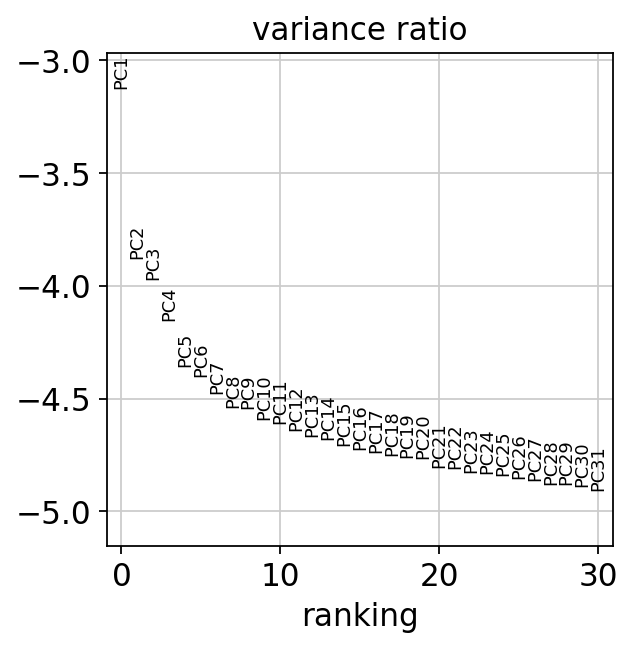

AnnData object with n_obs × n_vars = 184 × 2700
    obs: 'organs', 'batch', 'stage', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [18]:
forebrain = sc.pp.pca(forebrain, svd_solver='arpack', n_comps=50, return_info=True, copy=True)

pca = forebrain.uns['pca']
xpca = forebrain.obsm['X_pca']
vr = forebrain.uns['pca']['variance_ratio']

print('Figure 4')
sc.pl.pca_variance_ratio(forebrain, log=True, save='_fig4.pdf')

# Save these results
#forebrain.write(results_file)
forebrain

### Computing the Neighborhood Graph and UMAPs

To acccount for differences between the two biological replicates for each developmental stage sequenced, we batch-correct the data with the BBKNN algorithm.

We can compute a neighborhood graph of cells using a PCA representation of our data matrix. We can then use UMAPs or the Force Atlas algorithm for dimensionality reduction and visualizati son. We can appropriately adjust the number of principal components we select based on the above variance ratio plot.

In [19]:
sc.pp.neighbors(forebrain, n_neighbors=8, n_pcs=15)
sc.tl.umap(forebrain)
sc.tl.draw_graph(forebrain)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:00)


### Clustering

We can use the Leiden method for clustering our data.

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


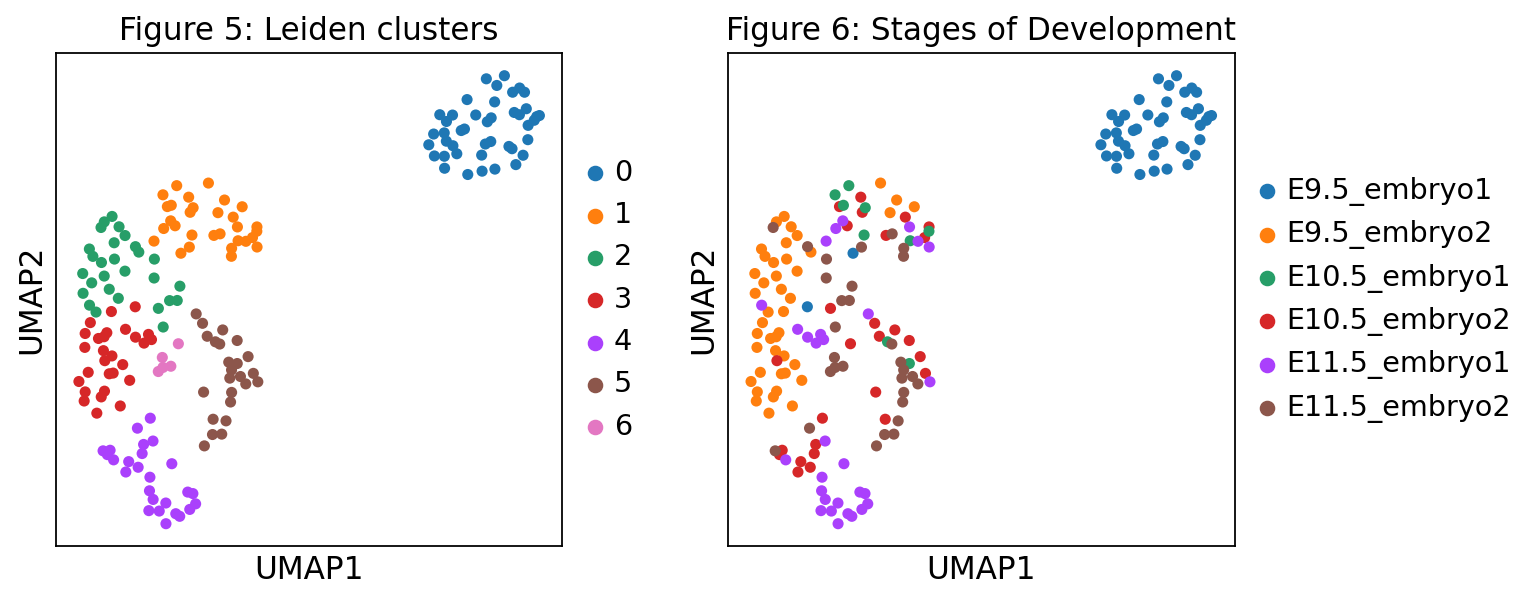

In [20]:
sc.tl.leiden(forebrain)
forebrain.write(results_file)
sc.pl.umap(forebrain, color=['leiden','batch'], title=['Figure 5: Leiden clusters', 'Figure 6: Stages of Development'],
           save = '_fig5.pdf', size=100)

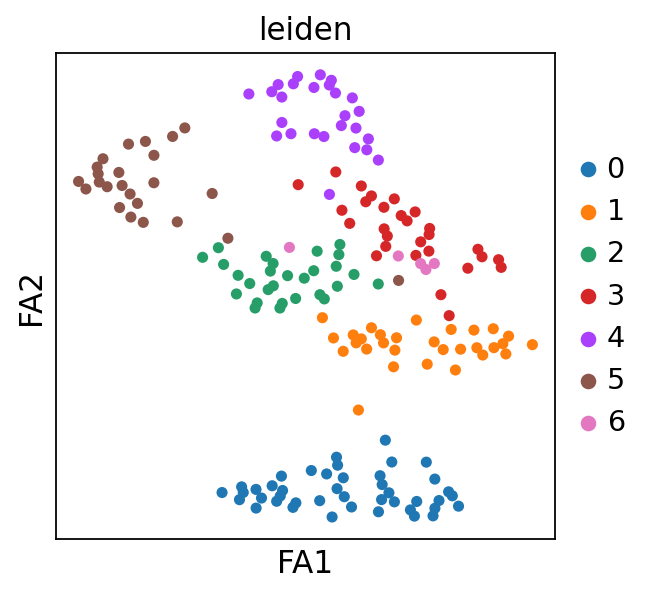

In [21]:
sc.pl.draw_graph(forebrain, color="leiden", size=100)

### Marker Genes and Cell Type Clustering

We need to annotate the cell types our clusters correspond to. Hu et al. provide marker genes for cell type, and we can score for cell type based on mean expression of these marker genes across each cluster. 

... storing 'cell_type' as categorical


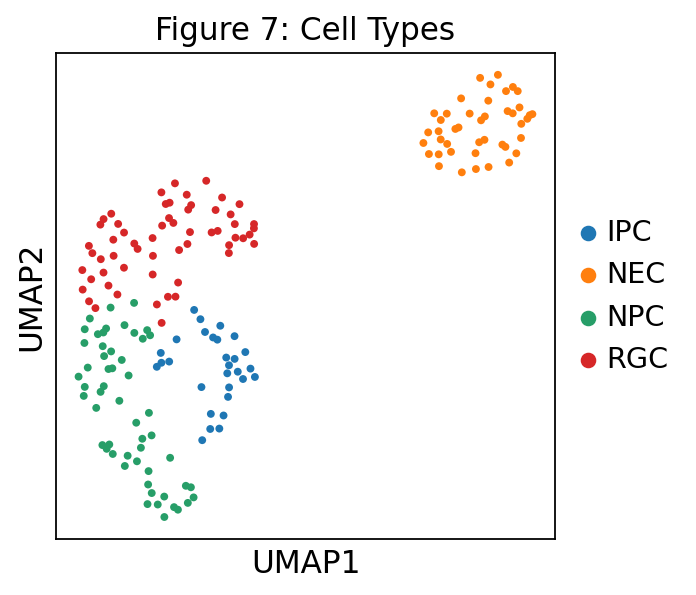

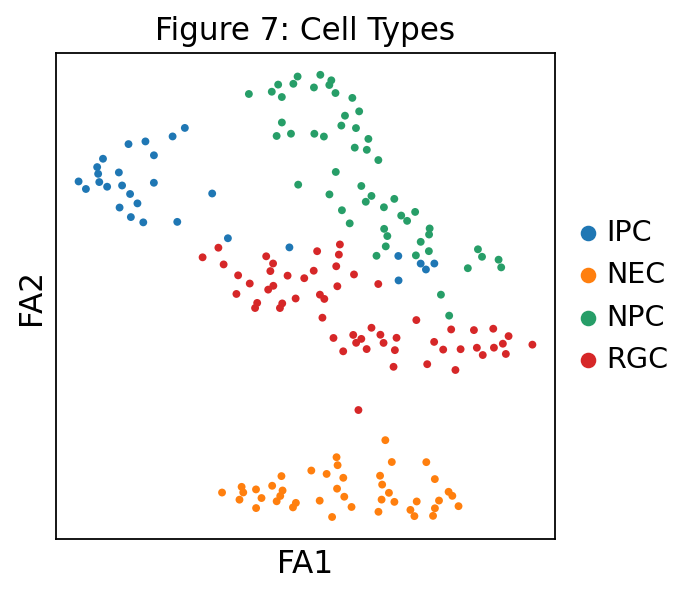

In [22]:
df = pd.read_csv(datadir+'forebrain_markers.csv', header=None, index_col=0)
marker_genes = {'NEC' : list(df.loc['NEC 1']) + list(df.loc['NEC 2']),
                'RGC' : list(df.loc['RGC']),
                'NPC' : list(df.loc['NPC']),
                'IPC' : list(df.loc['IPC'])
               }

cell_type_df = md.evaluate_partition(forebrain, marker_genes)

cell_type_dict = {}
for i in cell_type_df.columns:
    cell_type_dict[i] = cell_type_df[i].idxmax()

forebrain.obs['cell_type'] = forebrain.obs['leiden'].replace(cell_type_dict)

sc.pl.umap(forebrain, color='cell_type', size=50, title='Figure 7: Cell Types')
sc.pl.draw_graph(forebrain, color='cell_type', size=50, title='Figure 7: Cell Types')

In [23]:
forebrain_copy = forebrain.copy()

del forebrain.uns['neighbors']

In [24]:
forebrain.obsm['X_pca'] = forebrain.obsm['X_pca'][:,0:4]

/Users/niveditakanrar/opt/anaconda3/envs/surf_env2/lib/python3.8/site-packages/anndata2ri/py2r.py:37: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


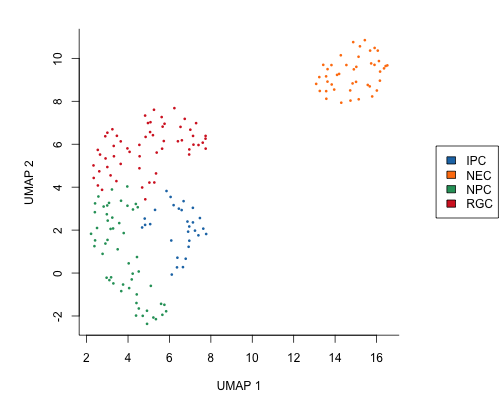

In [25]:
%%R -i forebrain -w 500 -h 400

par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(forebrain)$UMAP[,1], 
     reducedDims(forebrain)$UMAP[,2], 
     col=unlist(metadata(forebrain)$cell_type)[colData(forebrain)$cell_type], 
     bty='L', xlab='UMAP 1', ylab='UMAP 2', pch=16, cex=0.5)
legend("right", inset=c(-0.31,0), legend=sort(unique(colData(forebrain)$cell_type)), 
       fill=unlist(metadata(forebrain)$cell_type_colors))

In [26]:
%%time
%%R
print("1:")

forebrain_sling <- slingshot(forebrain, 
                           clusterLabels = 'leiden', 
                           reducedDim = 'UMAP',
                       start.clus = c("0"), 
                       end.clus = c("4", "5"))

print(SlingshotDataSet(forebrain_sling))

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
     184          2

lineages: 2 
Lineage1: 0  1  2  3  6  5  
Lineage2: 0  1  2  3  4  

curves: 2 
Curve1: Length: 17.65	Samples: 101.33
Curve2: Length: 21.824	Samples: 140.8
CPU times: user 1.64 s, sys: 104 ms, total: 1.74 s
Wall time: 438 ms


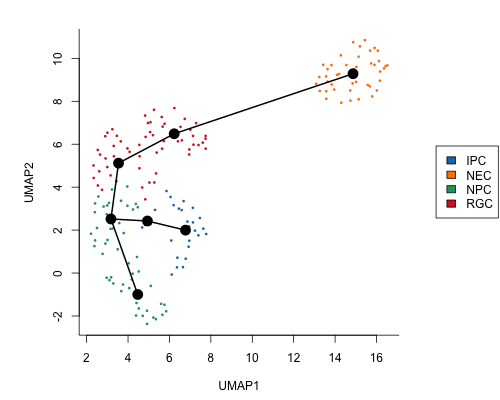

In [27]:
%%R -w 500 -h 400

par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(forebrain)$UMAP[,1], 
     reducedDims(forebrain)$UMAP[,2], 
     col=unlist(metadata(forebrain)$cell_type)[colData(forebrain)$cell_type], 
     bty='L', xlab='UMAP1', ylab='UMAP2', pch=16, cex=0.5)
lines(SlingshotDataSet(forebrain_sling), lwd=2, type = "lineages")

legend("right", inset=c(-0.31,0), legend=sort(unique(colData(forebrain)$cell_type)), 
       fill=unlist(metadata(forebrain)$cell_type_colors))

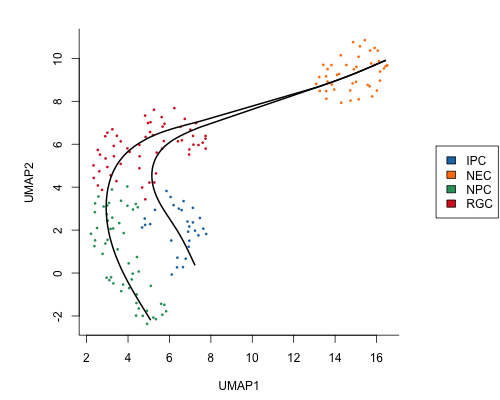

In [28]:
%%R -w 500 -h 400

par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(forebrain)$UMAP[,1], 
     reducedDims(forebrain)$UMAP[,2], 
     col=unlist(metadata(forebrain)$cell_type)[colData(forebrain)$cell_type], 
     bty='L', xlab='UMAP1', ylab='UMAP2', pch=16, cex=0.5)
lines(SlingshotDataSet(forebrain_sling), lwd=2)

legend("right", inset=c(-0.31,0), legend=sort(unique(colData(forebrain)$cell_type)), 
       fill=unlist(metadata(forebrain)$cell_type_colors))

In [29]:
# Subsetting the data prior to normalization as a DataFrame for DESingle DEG testing.
count_df = pd.DataFrame(pre_norm[forebrain.obs.index, 
                                     forebrain.var.index].X,
                       index = forebrain.obs.index,
                       columns=forebrain.var.index)
# We need to transpose the df because the single cell experiment object has cells as columns and genes as rows
count_df = count_df.T
count_df.shape

(2700, 184)

In [30]:
%%R -i count_df

# Exporting data for DEG analysis with DESingle
print(dim(count_df))

count_mtx <- as.matrix(count_df)
counts(forebrain_sling) <- count_mtx
logcounts(forebrain_sling) <- log10(count_mtx+1)
saveRDS(forebrain_sling, file = "./epithelial_mesenchymal_transition/forebrain/results/forebrain_sling.rds")

pseudotime <- slingPseudotime(SlingshotDataSet(forebrain_sling), na=FALSE)
cellWeights <- slingCurveWeights(SlingshotDataSet(forebrain_sling))

saveRDS(pseudotime, file="./epithelial_mesenchymal_transition/forebrain/results/pseudotime.rds")
saveRDS(cellWeights, file="./epithelial_mesenchymal_transition/forebrain/results/weights.rds")
saveRDS(count_mtx, file="./epithelial_mesenchymal_transition/forebrain/results/counts.rds")

saveRDS(SlingshotDataSet(forebrain_sling), file="./epithelial_mesenchymal_transition/forebrain/results/forebrain_sds.rds")

[1] 2700  184


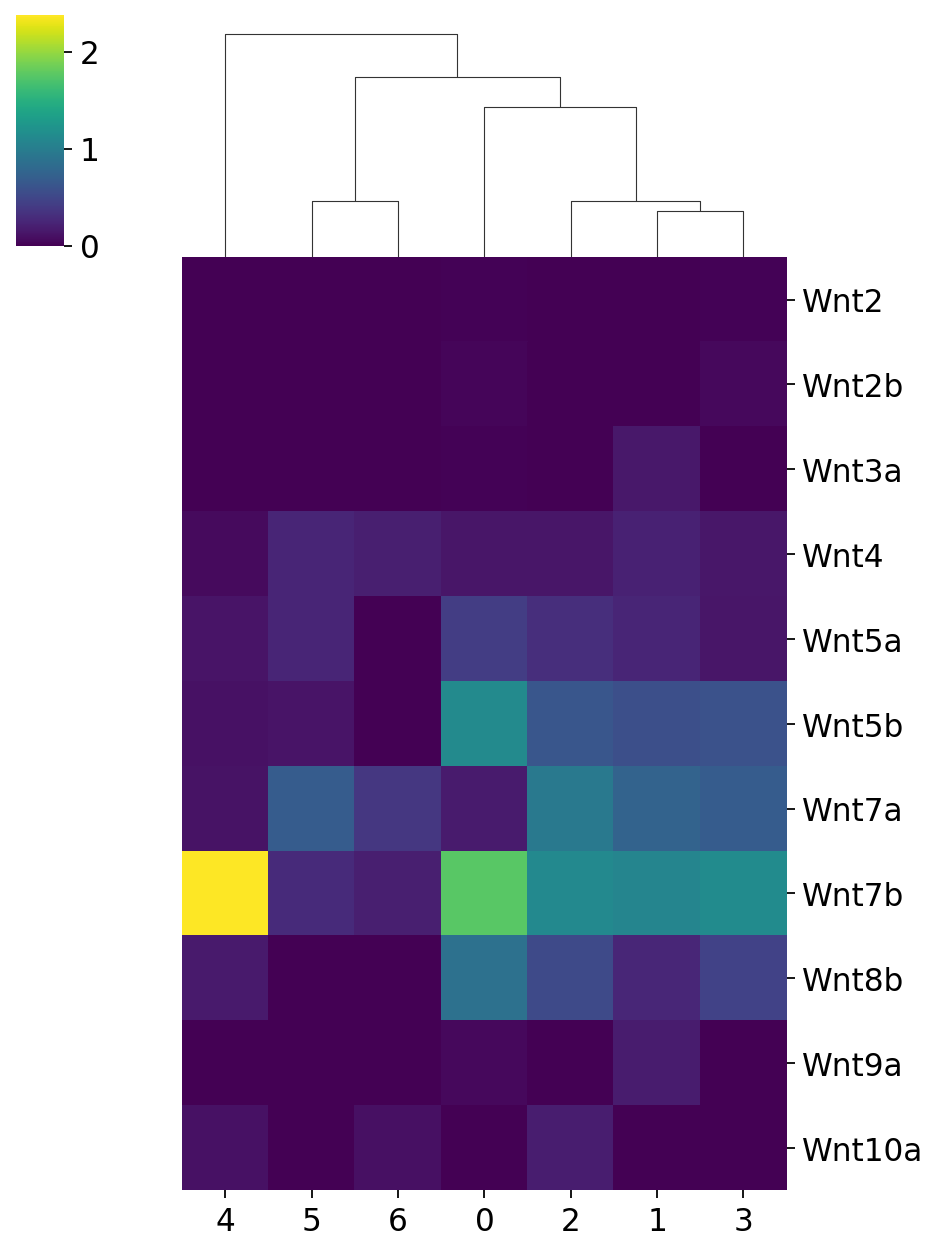

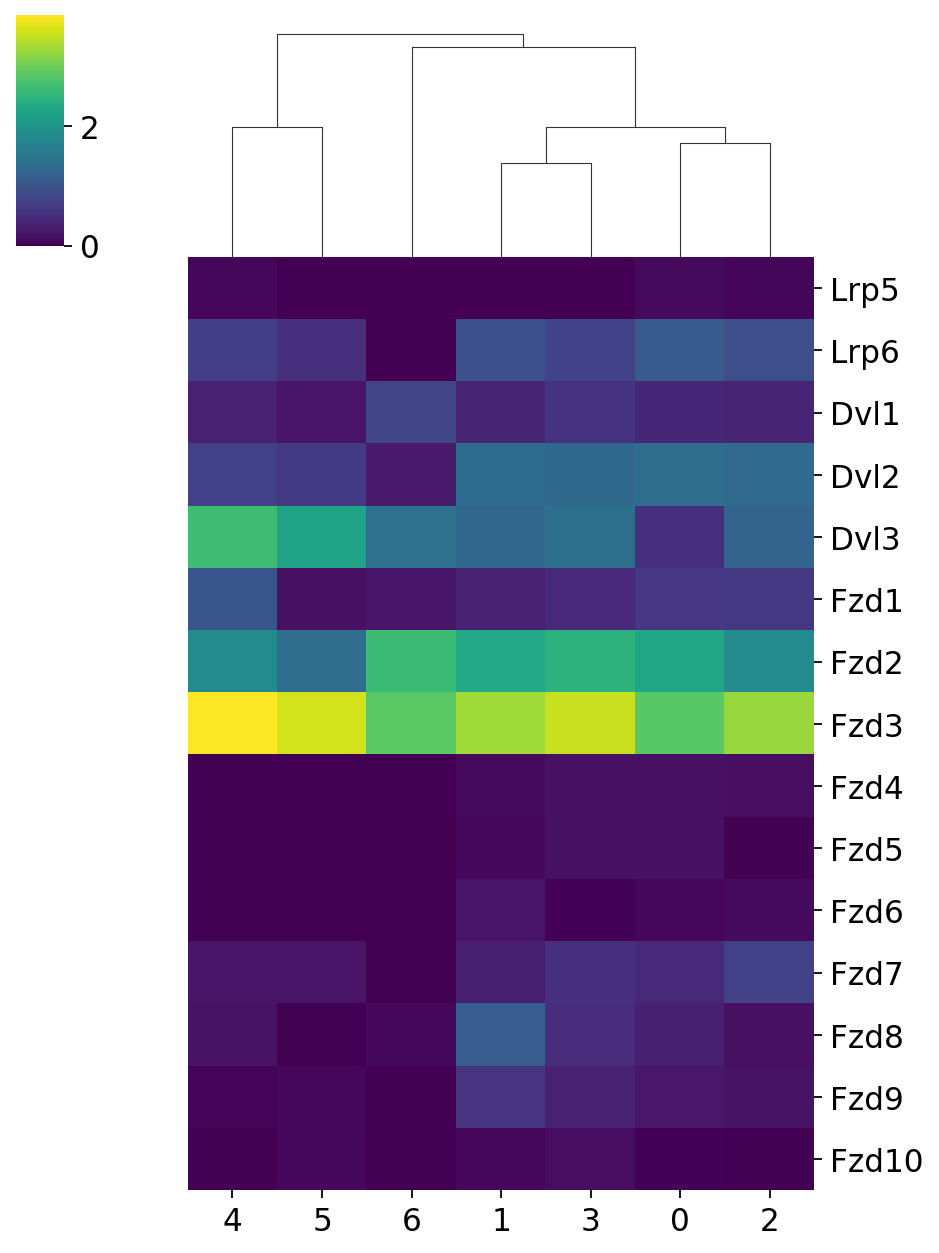

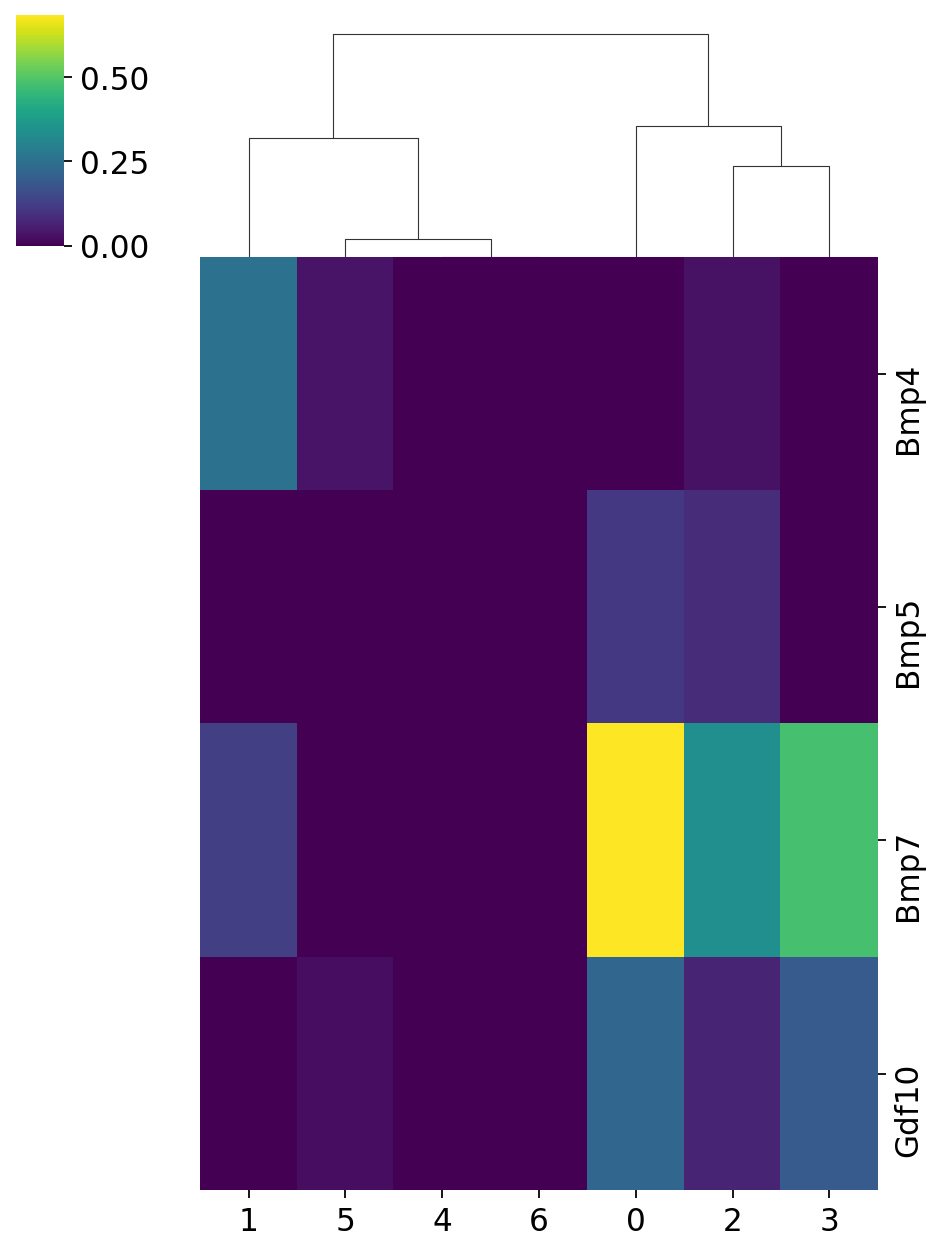

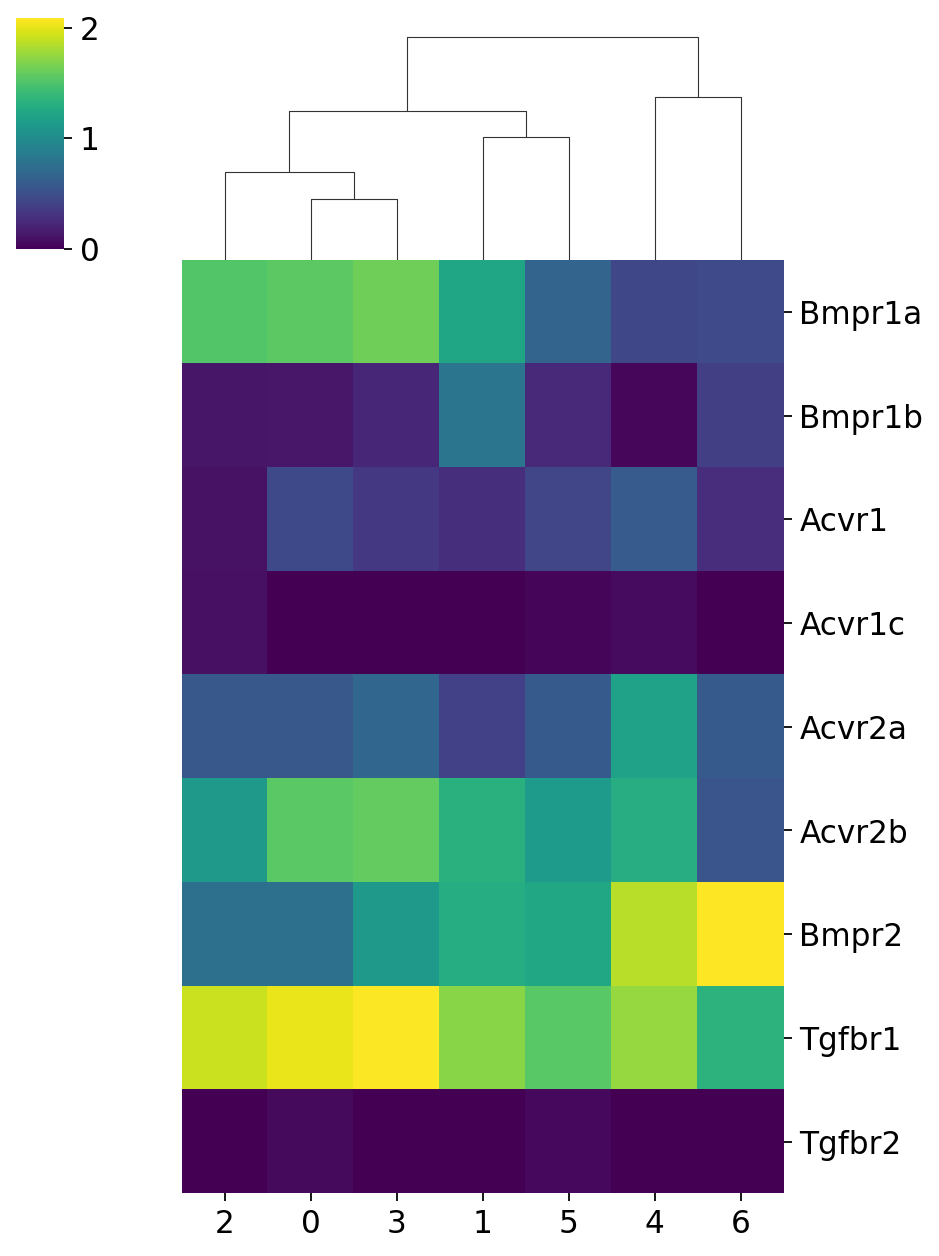

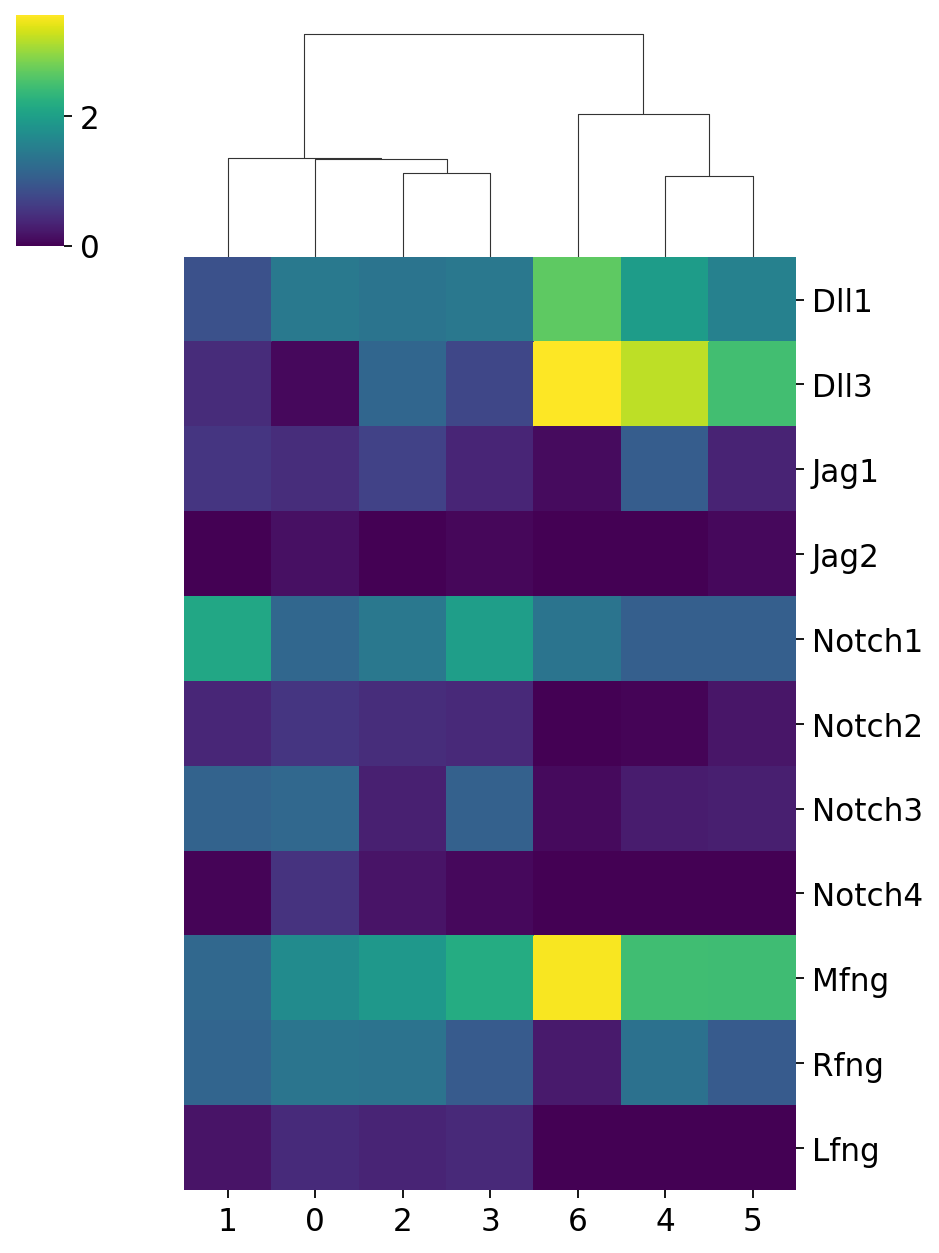

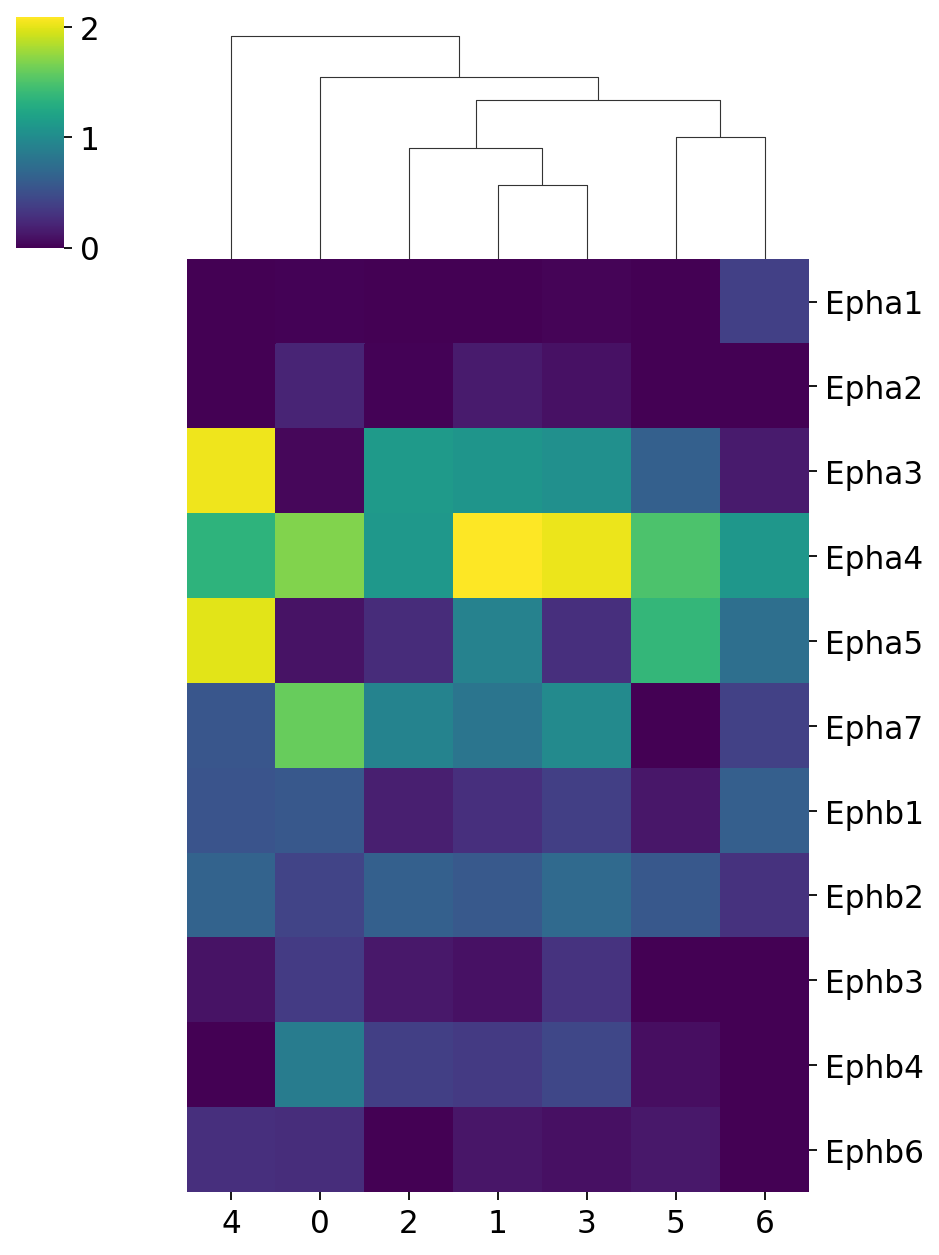

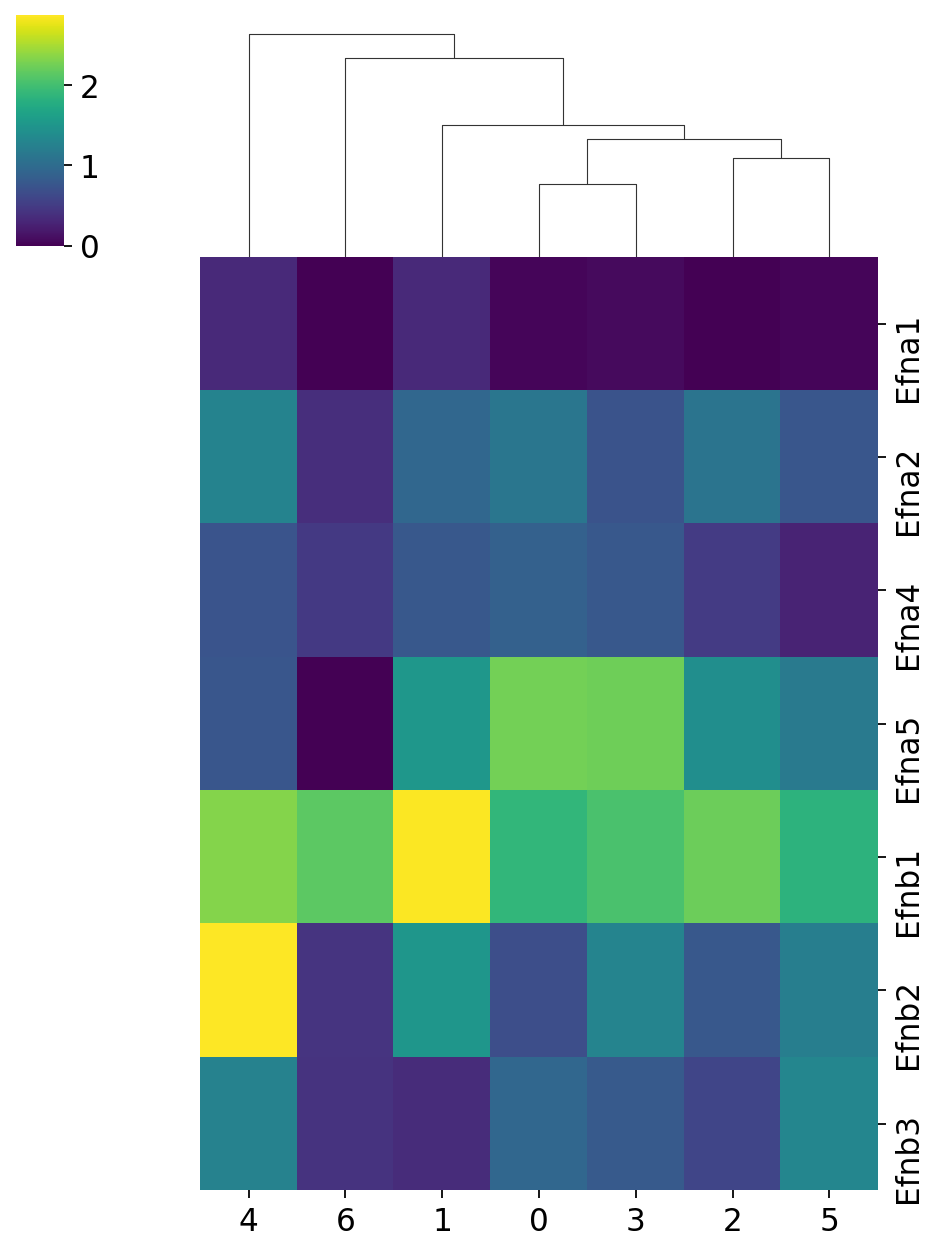

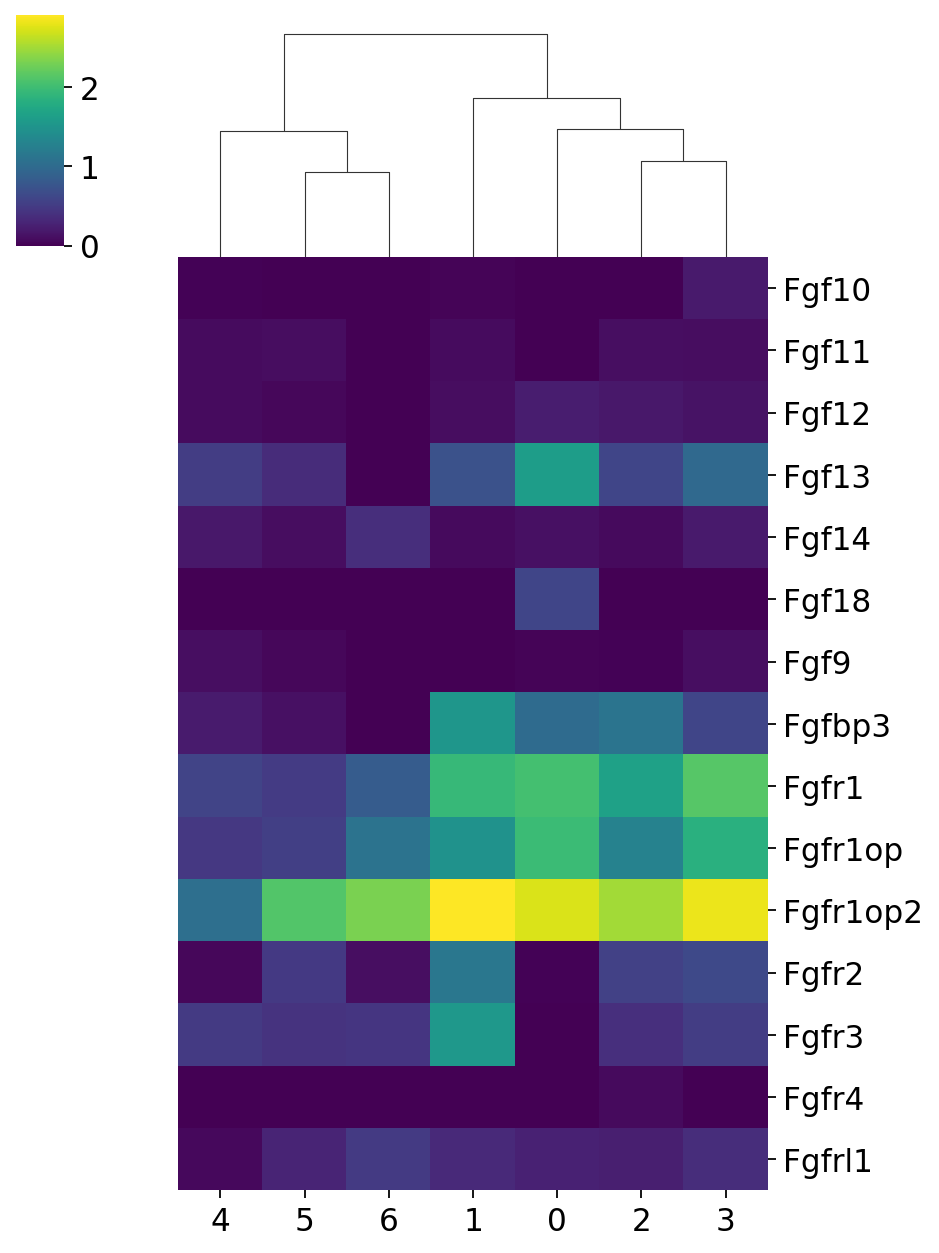

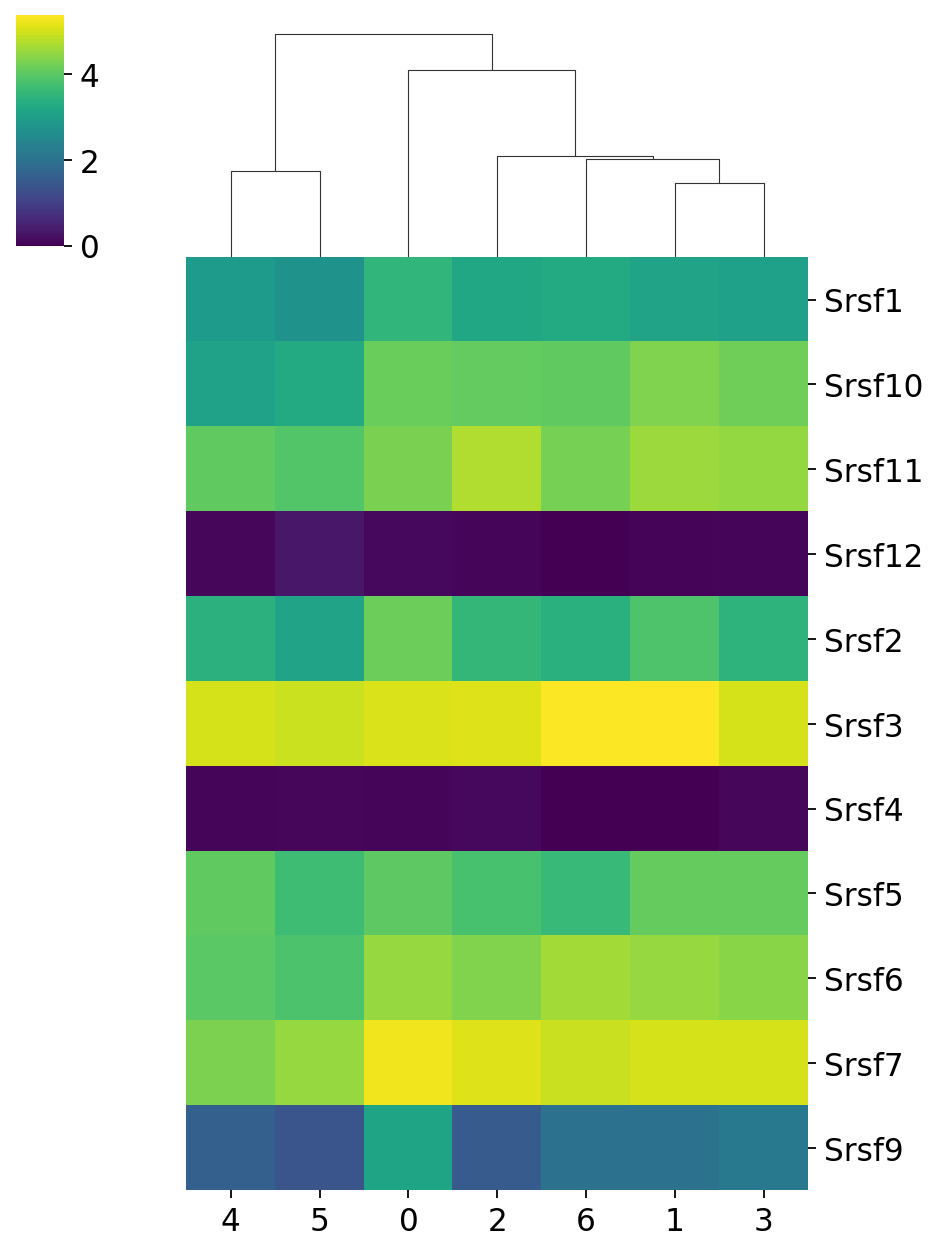

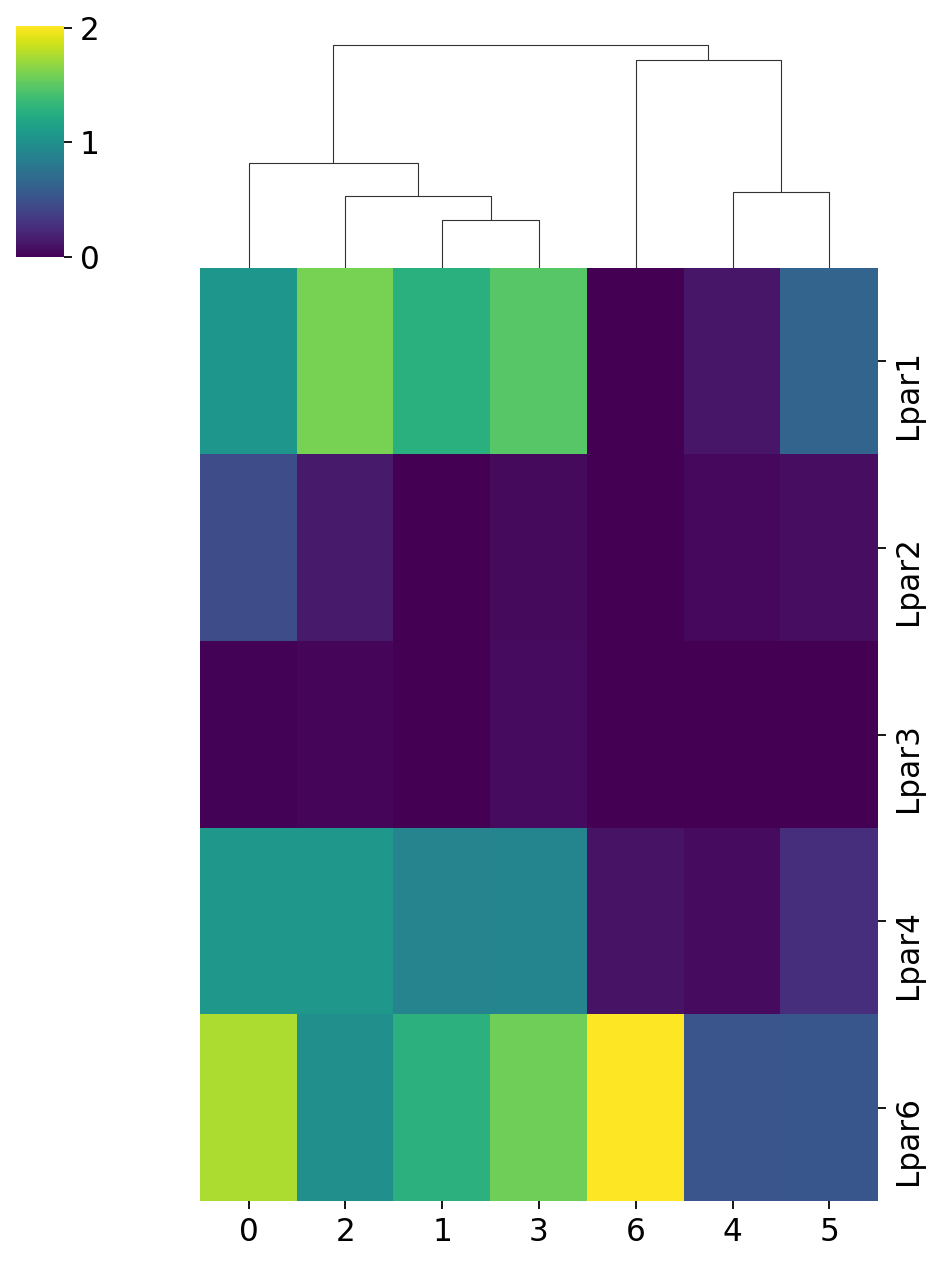

In [31]:
with PdfPages(figdir+ "forebrain_leiden_heatmap.pdf") as pdf:
    for idx,i in enumerate(list(pathways.keys())):
        # This is a dataframe of average gene expression for a pathway in each leiden cluster.
        df = md.gene_expression_norm(forebrain,pathways[i])
        # Plot heatmap
        g = sb.clustermap(df, cmap='viridis', row_cluster=False, figsize=(6,8))
        pdf.savefig(g.fig)

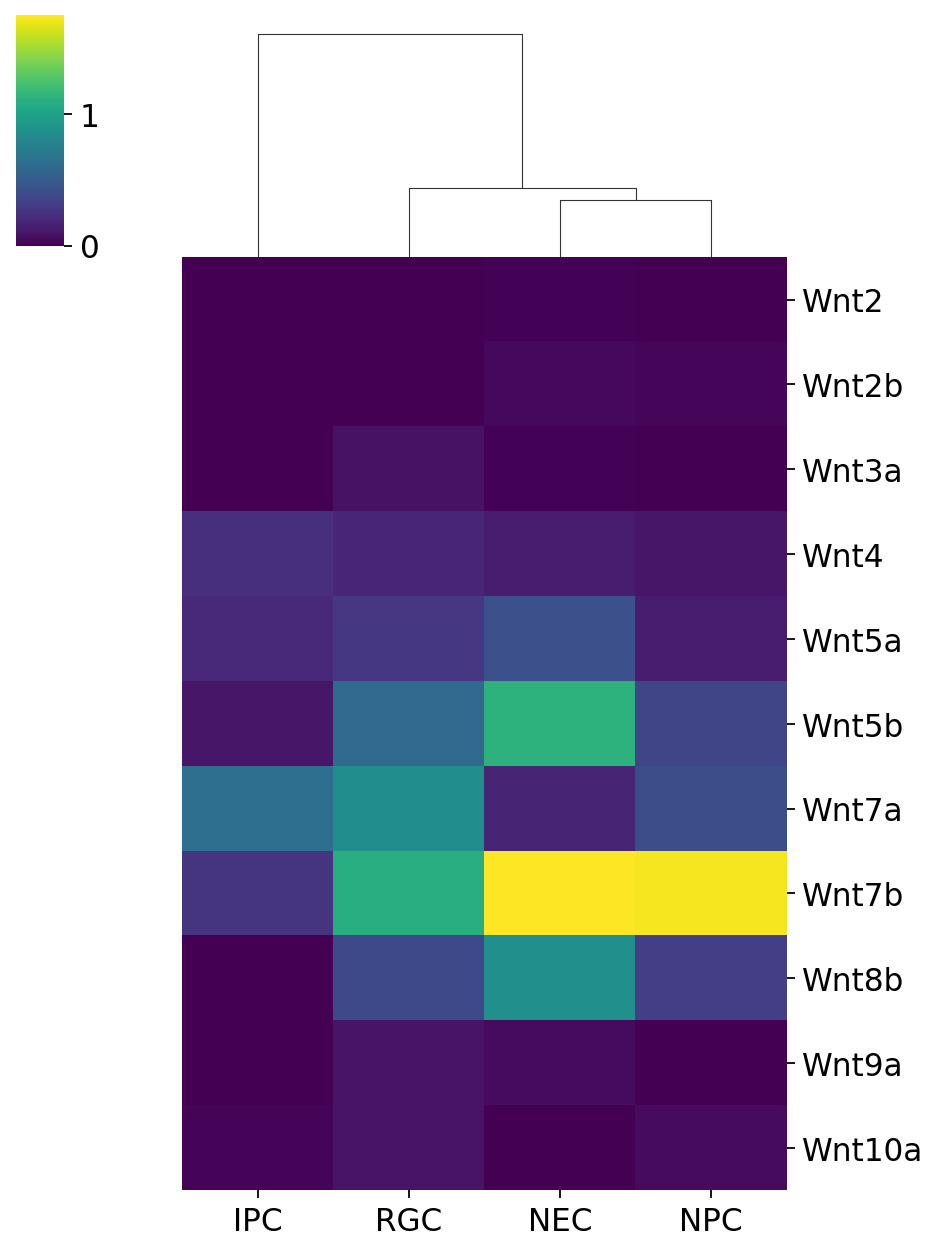

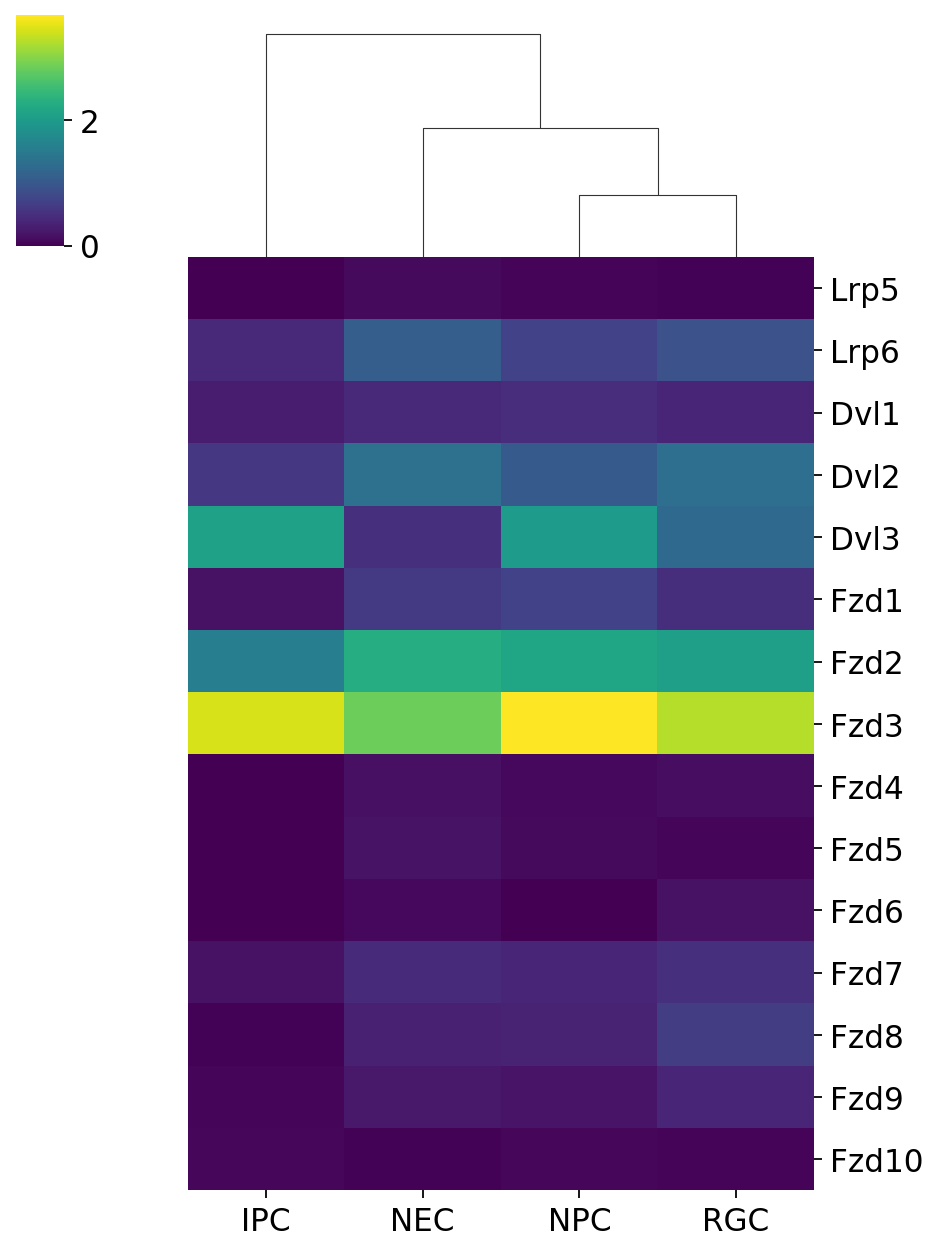

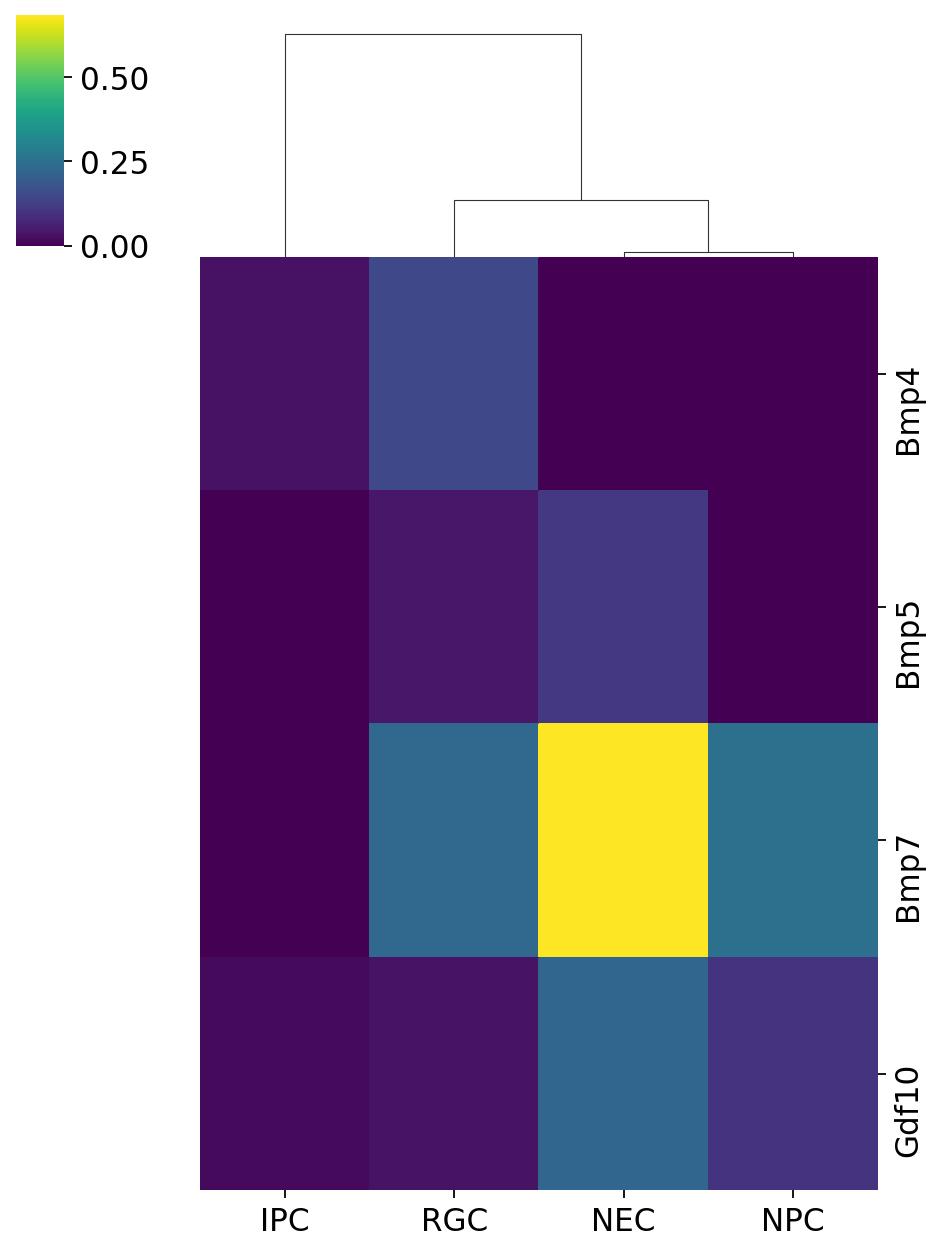

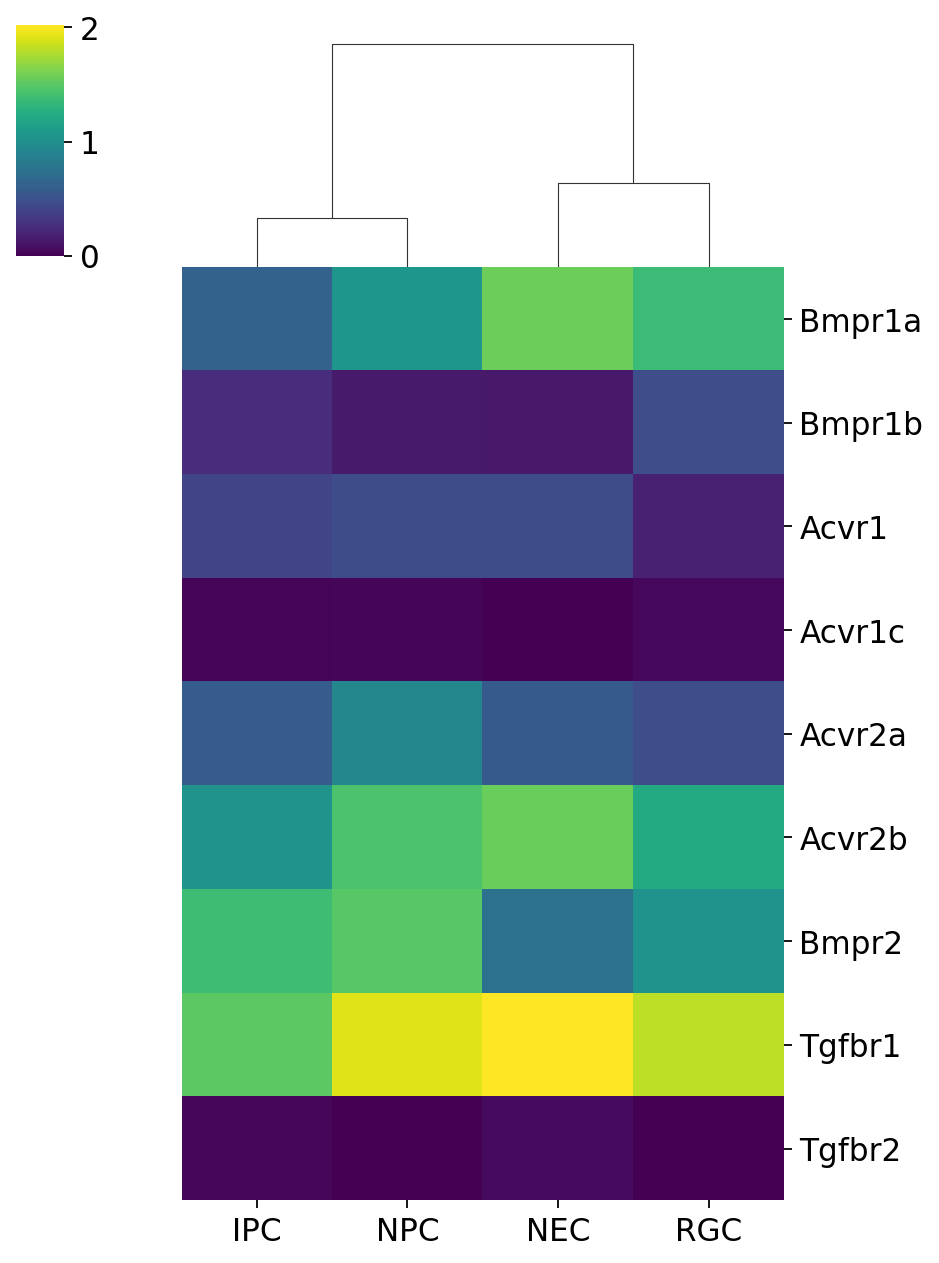

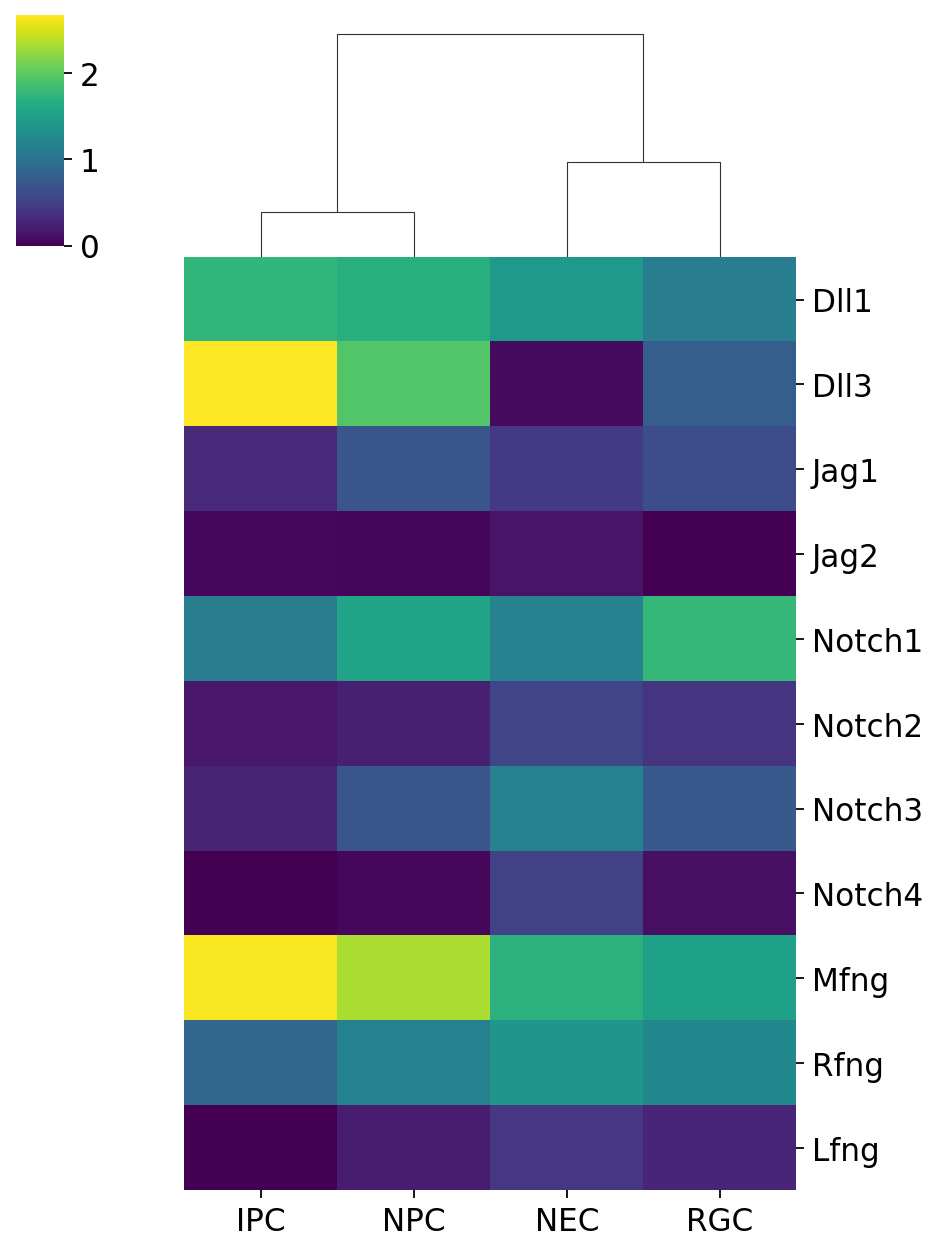

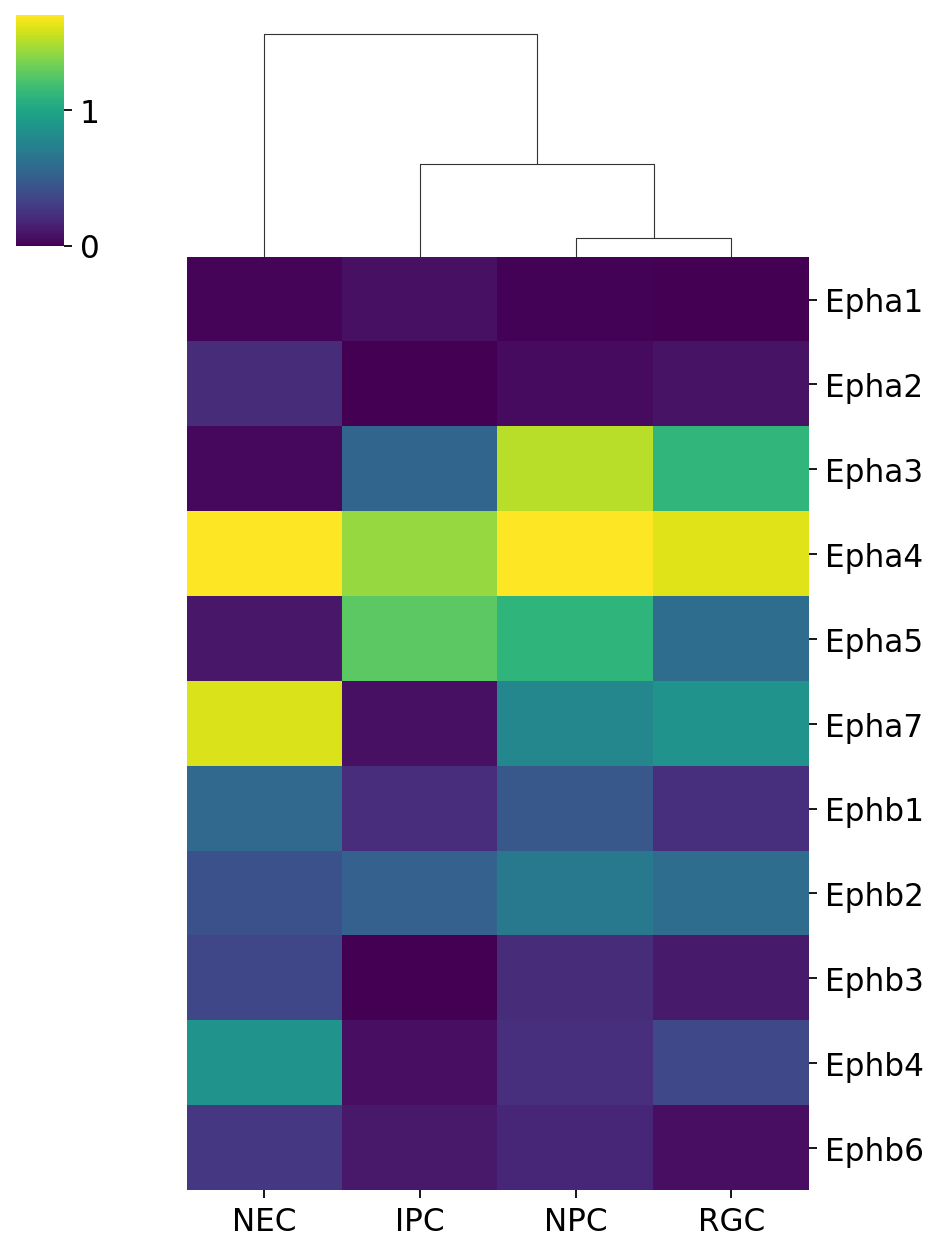

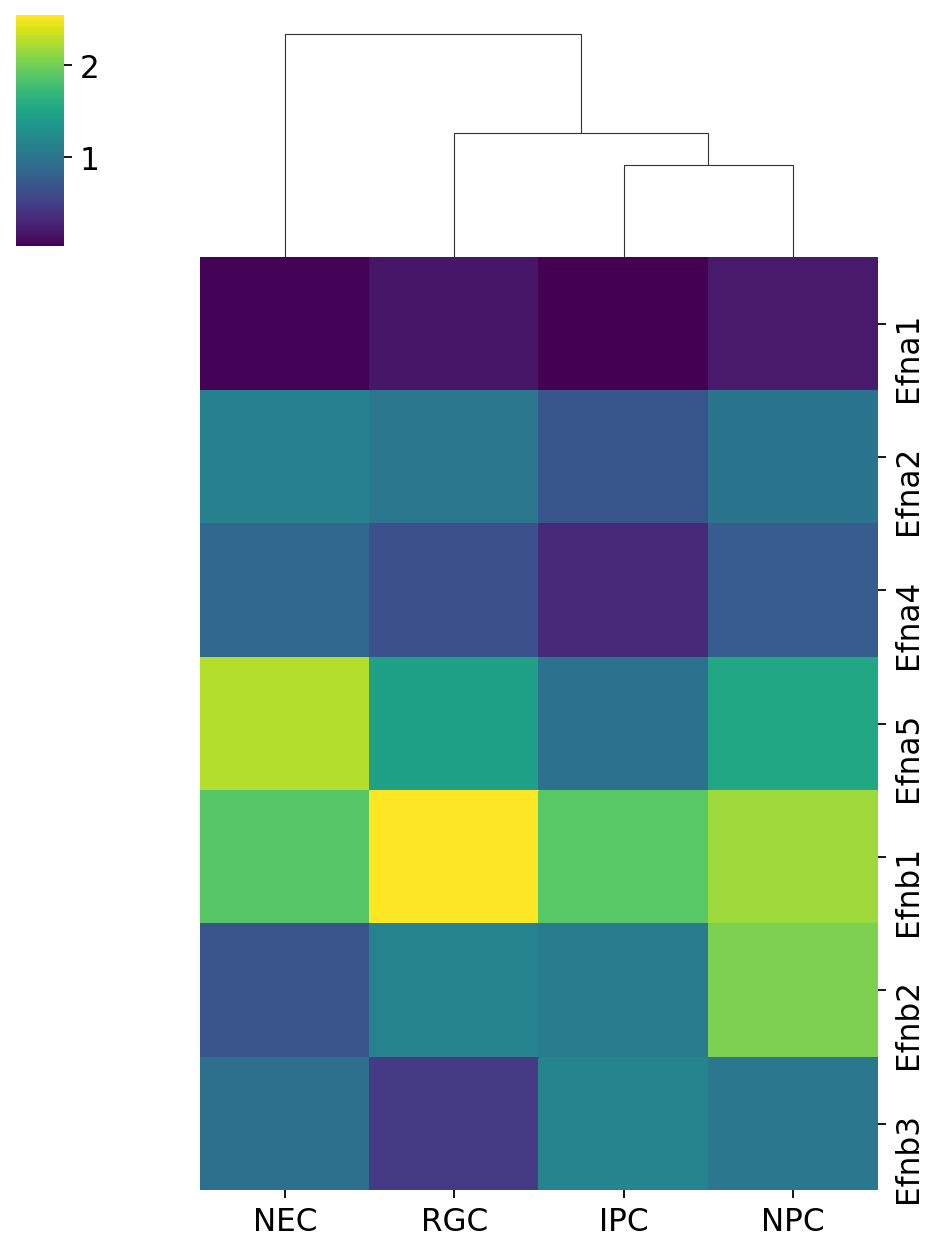

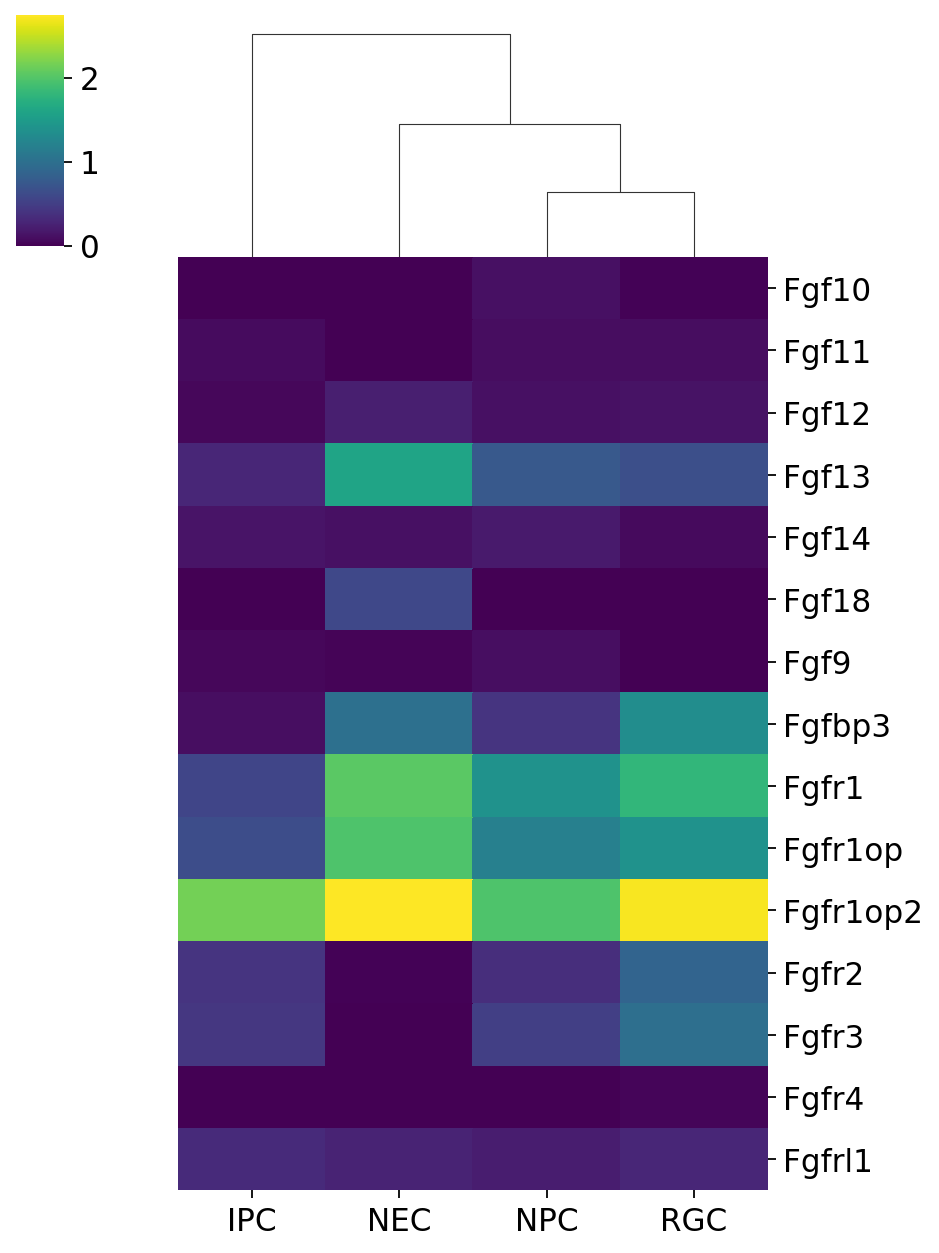

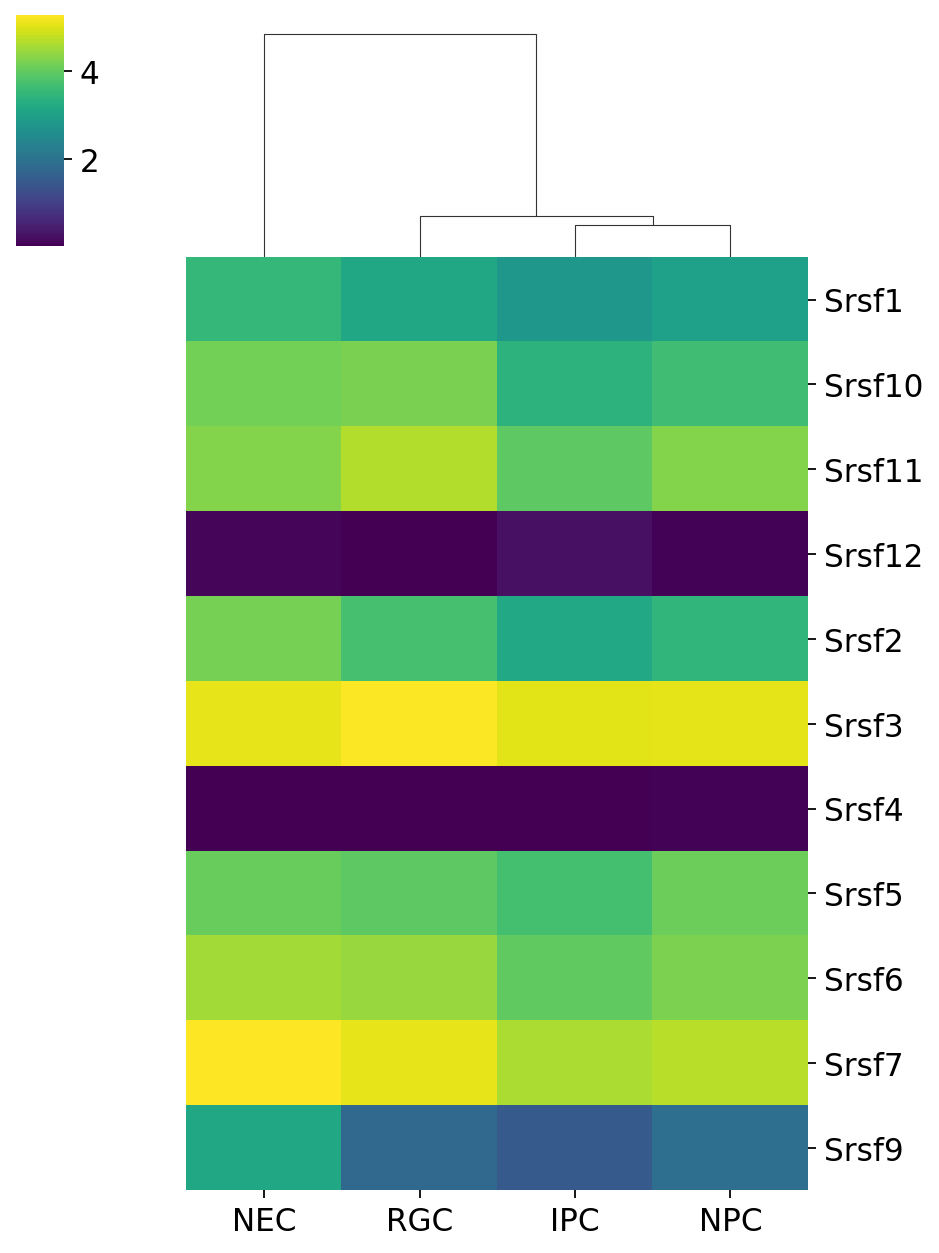

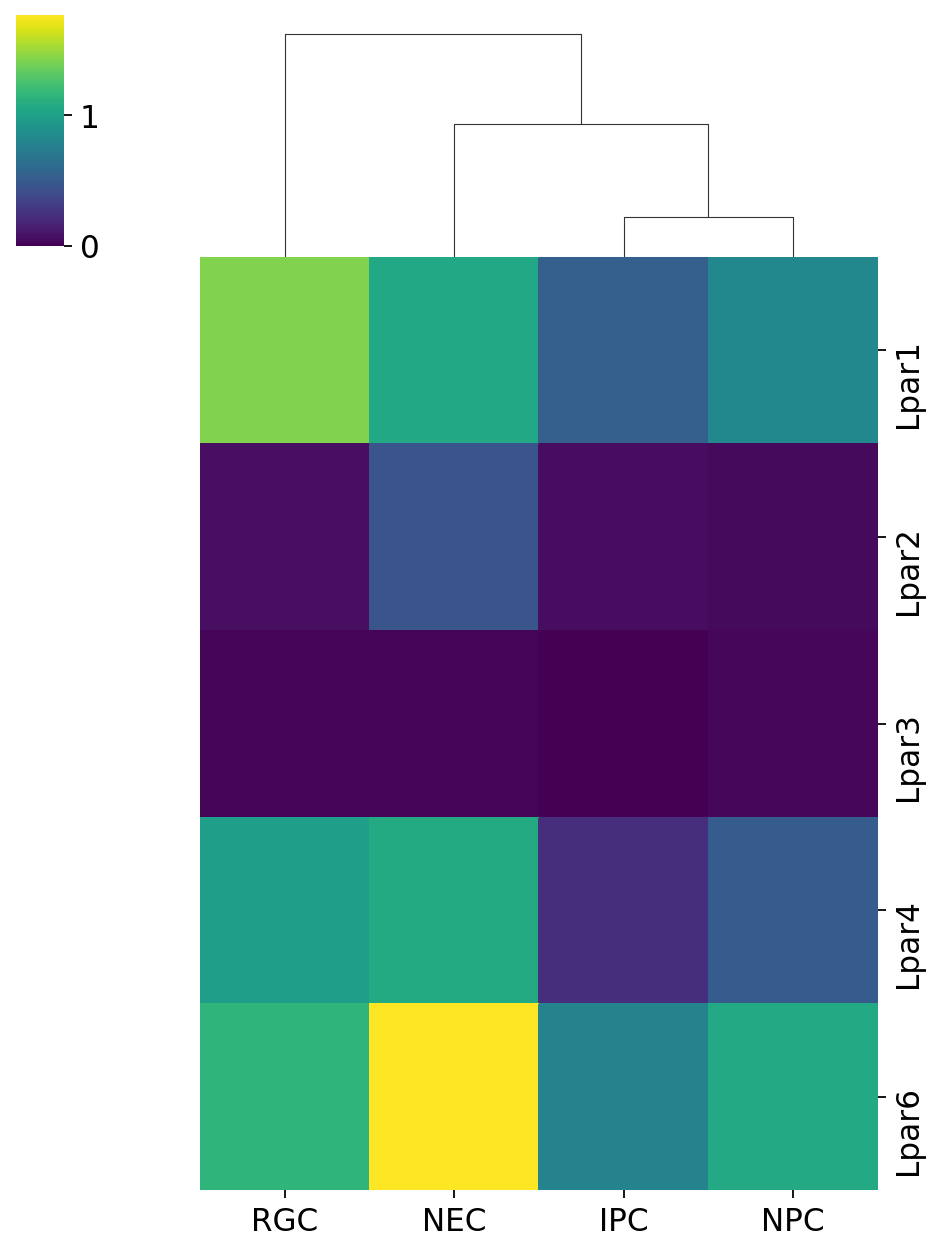

In [32]:
df_ann = pd.DataFrame()

for idx,i in enumerate(list(pathways.keys())):
    # This is a dataframe of average gene expression for a pathway in each leiden cluster.
    df = md.gene_expression_norm(forebrain, pathways[i], partition_key = "cell_type")
    if idx == 0:
        df_ann = df.T
    else:
        df_ann = pd.concat([df_ann, df.T], axis=1)
        
# Add annotations to the data
df_ann["cell_type"] = df_ann.index
df_ann["num_cells"] = [forebrain[forebrain.obs["cell_type"]==i].shape[0] for i in df_ann.index]


with PdfPages(figdir+ "forebrain_cell_type_heatmap.pdf") as pdf:
    for idx,i in enumerate(list(pathways.keys())):
        
        # Make a heatmap for each pathway
        g = sb.clustermap(df_ann[pathways[i]].T, cmap='viridis', row_cluster=False, figsize=(6,8),
                        metric="cosine")

        pdf.savefig(g.fig)